<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Введение</a></span></li><li><span><a href="#Подготовка-к-работе" data-toc-modified-id="Подготовка-к-работе-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка к работе</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Корреляция-и-мультиколлинеарность" data-toc-modified-id="Корреляция-и-мультиколлинеарность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Корреляция и мультиколлинеарность</a></span></li><li><span><a href="#Выбросы" data-toc-modified-id="Выбросы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выбросы</a></span></li><li><span><a href="#Важность-признаков" data-toc-modified-id="Важность-признаков-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Важность признаков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Задача

**Задача:** разработать алгоритм, подбирающий для определённого товара набор из пяти похожих на него. Качество алгоритма оценить по метрике accuracy@5

**Предоставленные данные:**

* **base.csv** - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

* **train.csv** - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков и id товара из base.csv, который максимально похож на него (по мнению экспертов).

* **validation.csv** - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

* **validation_answer.csv** - правильные ответы к предыдущему файлу.

# EDA

## Введение

Погружение в работу начнём с изучения данных и их предобработки. Импортируем необходимые библиотеки, загрузим и изучим данные. Проверим датасеты на пропущенные значения и дубликаты, изучим описательную статистику. Посмотрим на корреляцию и мультиколлинеарность между признаками. Данные довольно объёмные. Изучим возможность избавления от информации, которая плохо повлияет на обучение или никак на него влиять не будет. Выведем описательную статистику, гистограммы и боксплоты. Выстроим признаки датасета по важности. На основании полученных данных сделаем заключение для дальнейшей работы.

## Подготовка к работе

Импортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sn
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler

Настроим работу в среде разработки и работу с датасетами.

In [2]:
pd.set_option('display.max_columns', 80)

In [3]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Загрузка данных

Загрузим анонимизированный набор товаров.

In [5]:
df_base = pd.read_table("base.csv", index_col=0, sep=',', dtype=dict_base)
df_base.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,-124.061508,-32.458237,-57.420559,36.207405,182.716766,-28.071688,-5.209374,-1.732183,-91.091858,-79.466667,-103.939087,1507.231323,-32.591667,51.414360,-51.905361,813.770081,-41.556538,8.419807,-129.976639,148.765030,-10.069234,-143.005035,79.848694,-537.183716,2.773180,111.518677,4.257666,-153.340576,-123.626083,-39.707664,-12.768708,-4.170106,-152.967133,75.911522,-57.470089,17.266476,-98.871155,-138.067535,91.000381,-170.701996,-50.020390,59.794296,78.106377,-89.375725,89.412102,79.81218,-129.513611,-44.659496,-80.442207,5.149714,-64.518951,-138.777634,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,-141.304352,-126.768898,-68.853531,8.314717,143.081741,8.778257,15.157185,48.246361,-244.954865,-80.279419,-81.788040,429.880035,-5.937690,70.142654,66.576843,813.770081,3.214371,17.164303,-39.418385,148.155884,-7.579590,-174.369949,101.224632,-303.939240,16.914631,53.394676,33.451824,-148.552628,-110.340172,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948471,62.484821,-166.473358,-189.010422,-56.731556,-30.027319,59.171059,-56.711540,63.542606,-121.319168,97.426056,74.83284,-138.777054,58.887608,-71.595337,-251.952362,11.392853,-148.571655,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,-140.822449,-22.486748,-51.666988,2.521726,140.585449,-22.039230,-7.128633,-5.184787,-111.712120,-79.029266,-82.452576,1507.231323,-0.421011,84.108009,63.344509,813.770081,-105.211052,18.844700,-94.789474,151.387711,-21.483440,-144.845367,48.502934,-780.449158,64.767311,79.781555,-13.390142,-150.061661,-118.758553,-40.896286,-15.222620,-1.860338,-93.820656,98.749069,-46.745781,65.927475,-10.286392,-125.321373,21.048609,-22.637775,68.915985,-54.902260,66.335472,-142.927917,83.030983,69.97963,-123.733887,65.320877,-114.037178,-529.396973,-101.581375,-134.658218,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206


In [6]:
df_base.shape

(2918139, 72)

Загрузим обучающий датасет.

In [7]:
df_train = pd.read_csv("train.csv", index_col=0, dtype=dict_train)
df_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,-88.082687,-52.695541,-27.692442,4.872923,198.348007,-30.075249,-3.803569,-135.810608,-161.841370,-78.512177,-94.428940,898.436951,-70.140518,78.420357,108.032776,813.770081,-74.790878,12.610422,-183.821838,149.715836,-27.042316,-133.212173,106.420746,-303.939240,48.730789,58.185707,24.250950,-151.224106,-104.282265,-34.492809,-12.587054,2.622891,-120.969917,149.991638,-31.948471,82.314430,-115.830467,-243.309387,6.622036,-132.197662,68.712563,-38.806824,62.937435,-132.654449,89.189026,87.039780,-121.279877,-6.986934,-206.513824,29.485588,-77.029587,-132.386169,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,-177.605804,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267029,-78.659431,-92.761490,353.157745,-34.744545,82.487106,-28.450592,813.770081,-137.529633,26.595627,-136.783447,153.357910,48.810093,-115.922150,87.464218,-222.286362,25.124149,91.887138,-30.636869,-136.593140,-140.500122,-43.449757,-7.226884,8.265747,-117.915466,149.150894,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061081,-7.139753,75.862396,-112.045113,82.857727,54.067215,-134.005386,-26.142574,-214.632111,-457.848450,21.459618,-137.411362,-40.812233,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,-86.346558,-35.666546,16.395317,-80.802849,137.908646,-23.532761,-47.256584,-16.650242,-194.505676,-78.372925,-69.324478,1507.231323,-52.500969,-34.165775,52.958652,813.770081,-18.021725,20.951107,-50.321781,158.760620,0.178065,-183.069672,99.053574,-1018.469543,-51.801121,97.766769,-10.865850,-144.423157,-133.819489,-78.902298,-17.200352,4.467452,-63.970737,154.639526,-30.211615,48.527401,-122.406639,-112.713623,53.461838,-31.117260,107.841507,16.482935,77.934479,-95.618729,91.460075,63.119511,-126.939247,8.066628,-195.677673,-163.119995,-72.830002,-139.223068,-52.031662,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base


Загрузим тестовый датасет.

In [8]:
df_valid = pd.read_csv("validation.csv", index_col=0, dtype=dict_base)
df_valid.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,-131.892807,-140.968567,-57.987164,-22.868887,150.895523,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579521,263.363129,56.266876,66.924713,21.609911,813.770081,-32.782940,20.794031,-79.779076,156.307083,-42.831329,-71.723335,83.283661,-304.174377,1.609402,55.834587,-29.474255,-139.162766,-126.038353,-62.643829,-5.012346,11.984921,-43.084946,190.123993,-24.996635,76.153900,-245.261566,-143.656479,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697319,60.475632,-127.486870,-39.484753,-124.384575,-307.949768,45.506813,-144.190948,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,-153.717255,-63.951328,-52.369495,-33.390945,148.619507,-22.483829,15.164185,-56.202000,-153.614380,-79.831825,-101.055481,1203.537109,81.597130,101.018654,56.783424,92.209625,-126.860336,10.382887,-38.523361,165.383911,-77.840485,-169.538681,103.483238,-915.735718,16.109938,14.669937,-38.707085,-149.538376,-138.792923,-36.076176,-2.781422,2.283144,-142.477890,189.953949,-18.408230,90.517052,-95.530998,-259.636047,52.437836,-30.004599,14.502060,-1.071201,66.842667,-161.279892,94.794174,50.419983,-125.075256,-25.169033,-176.176880,-655.836914,-99.238373,-141.535217,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,-220.309540,-31.378445,-8.788761,2.285323,133.266113,-41.309078,14.305538,-18.231812,-205.533707,-78.160309,-96.607674,1507.231323,-5.964200,34.937443,-56.086887,813.770081,-13.200474,18.966661,-35.110191,151.368500,-17.490252,-145.884293,15.533379,-655.395508,39.412827,62.554955,9.924992,-143.934616,-123.107796,-37.032475,-13.501337,12.913328,-116.038017,176.276154,-45.909943,103.491364,-90.656990,-162.615707,117.128235,13.079479,69.826889,-6.874451,63.707214,-123.851067,91.610817,59.760067,-129.566177,-12.822194,-154.197647,-407.199066,5.522629,-126.812973,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,-114.271957,-71.406456,-65.349319,24.377069,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690697,-139.227448,325.547119,3.632292,74.929504,-4.802103,813.770081,-52.982597,15.644382,-54.087467,151.309143,21.088570,-134.507889,65.118958,-529.295044,131.565521,67.642700,-22.884491,-145.906525,-86.917328,-11.863579,-22.188885,0.463720,-212.533752,170.522583,-48.092533,99.712555,-194.692413,-141.523178,60.217049,73.386383,118.567856,58.900810,55.569031,-181.091660,83.340485,66.083237,-114.048866,-57.156872,-56.335075,-318.680054,-15.984783,-128.101334,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,-76.214172,-26.393860,34.423641,50.938889,157.683182,-23.786497,-33.175415,-0.592607,-193.318542,-79.651031,-91.889786,1358.481079,44.027733,121.527206,46.182999,433.623108,-82.233200,21.068508,-32.940117,149.268951,0.404718,-97.674530,81.719994,-825.644775,9.397169,49.359341,17.725466,-160.168152,-129.367950,-55.532898,-2.597821,-0.226103,-41.369141,92.090195,-58.626858,73.655441,-10.257370,-175.656784,

Данные загружены и выведены на экран. Датасеты довольно объёмные, каждый товар характеризуется 72 признаками. Признаки зашифрованы, значения непрерывные. Изучим данные подробнее.

## Изучение данных

In [9]:
dframes = {
    'Анонимизированный набор товаров': df_base,
    'Обучающий': df_train
}

for i, j in dframes.items():
    print()
    print('\033[1m' + '\033[01;04;38;05;23m' + 'ДАННЫЕ ПО ДАТАФРЕЙМУ', i+ '\033[01;00;38;05;23m')
    print()
    print('\033[1m' + '\033[01;38;05;30m' + '1. Изучим информацию о датафрейме:' + '\033[0m')
    print()
    display(j[['0','1','2']].info())
    print()
    print('\033[1m' + '\033[01;38;05;30m' +'2. Определим, в каких столбцах есть пропуски:')
    display(j.isna().sum())
    print('\033[1m' + '\033[01;38;05;30m' +'3. Проверим данные на полные дубликаты:')
    display(j.duplicated().sum())
    print()
    print('\033[1m' + '\033[01;38;05;30m' +'4. Выведем описательную статистику:')
    display(j.describe(exclude=['object']).round(2))


ДАННЫЕ ПО ДАТАФРЕЙМУ Анонимизированный набор товаров

1. Изучим информацию о датафрейме:

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
dtypes: float32(3)
memory usage: 55.7+ MB


None


2. Определим, в каких столбцах есть пропуски:


0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

3. Проверим данные на полные дубликаты:


0


4. Выведем описательную статистику:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00
mean,-86.23,8.08,-44.58,-146.69,111.31,-72.01,-392.33,20.35,124.58,124.47,-143.14,-69.90,-41.27,7.59,149.00,-23.17,-0.94,-19.32,-137.25,-79.85,-98.25,1272.43,-6.83,56.68,26.70,711.63,-66.26,16.32,-86.38,152.34,-11.61,-144.22,87.21,-553.42,36.23,75.19,-16.49,-147.00,-118.62,-41.88,-9.48,4.05,-112.74,120.87,-39.81,58.93,-84.90,-138.45,47.93,-32.38,26.59,-21.72,66.99,-117.89,88.02,69.21,-132.09,13.23,-119.62,-316.04,-64.94,-130.33,-79.03,33.30,-154.78,14.15,66.58,23.55,74.96,115.60,-789.20,-47.79
std,24.86,4.95,38.59,19.82,46.28,28.15,270.84,64.13,6.41,64.34,41.63,51.16,38.92,36.56,33.59,13.06,20.81,52.91,46.56,1.00,28.12,401.66,51.91,34.32,38.90,205.21,61.45,4.65,48.45,10.10,28.91,34.71,27.82,260.19,39.85,21.42,25.82,9.95,13.13,19.18,8.18,5.83,56.87,46.66,14.74,32.07,63.11,57.66,45.14,58.21,58.88,51.68,13.06,54.64,4.77,11.93,7.85,51.02,55.18,210.49,62.40,9.56,30.42,28.85,41.17,98.87,2.19,55.27,61.26,21.15,381.93,41.69
min,-199.47,-13.91,-240.07,-232.67,-105.58,-211.01,-791.47,-301.86,93.15,-173.87,-343.84,-368.45,-226.09,-175.62,-15.27,-85.92,-96.37,-272.57,-351.75,-83.15,-243.73,136.82,-238.29,-88.18,-143.18,-61.98,-358.55,-8.36,-314.01,107.44,-156.73,-298.68,-34.65,-1045.31,-137.85,-21.52,-137.99,-195.42,-176.91,-132.71,-47.58,-21.58,-338.12,-87.71,-63.10,-77.25,-362.93,-418.70,-145.39,-322.81,-280.27,-264.63,6.20,-381.26,65.58,14.08,-167.06,-196.18,-359.71,-681.04,-400.79,-171.35,-220.57,-88.51,-353.90,-157.59,59.51,-233.14,-203.60,15.72,-1297.93,-226.78
25%,-103.07,4.71,-69.56,-159.91,80.51,-91.38,-629.33,-22.22,119.48,81.77,-170.32,-104.03,-66.63,-16.94,125.97,-31.77,-15.15,-55.46,-167.59,-79.68,-116.84,1088.60,-42.24,33.30,0.56,813.77,-107.85,13.26,-118.66,144.89,-30.75,-167.04,68.30,-771.30,9.35,60.91,-34.14,-153.27,-127.45,-54.79,-14.98,0.04,-151.59,88.20,-52.87,36.99,-128.20,-176.60,17.90,-69.95,-12.33,-56.28,58.46,-154.49,84.71,61.31,-138.10,-22.39,-157.43,-498.48,-106.55,-137.39,-98.76,16.99,-180.78,-71.30,66.58,-12.52,33.78,101.69,-1074.46,-75.67
50%,-86.23,8.04,-43.82,-146.78,111.87,-71.92,-422.20,20.80,123.89,123.50,-141.72,-70.23,-40.40,8.13,149.31,-22.91,-1.03,-19.80,-136.80,-79.18,-97.53,1507.23,-6.42,57.00,27.13,813.77,-66.20,16.39,-85.54,151.64,-11.19,-144.12,86.87,-529.30,35.32,74.61,-16.32,-146.72,-118.60,-42.03,-9.47,4.05,-113.06,119.90,-40.03,58.96,-85.11,-137.38,46.97,-29.17,27.51,-22.21,67.22,-117.63,88.01,69.36,-132.83,13.11,-120.46,-315.99,-63.69,-130.88,-78.49,34.72,-153.98,13.83,67.81,23.42,74.93,116.02,-1074.46,-48.59
75%,-69.26,11.47,-19.63,-133.33,142.37,-52.44,-156.67,63.92,127.97,167.22,-114.99,-35.70,-14.84,32.67,172.16,-14.34,13.37,16.59,-107.54,-78.68,-79.24,1507.23,28.23,79.66,53.09,813.77,-25.58,19.44,-53.88,158.28,8.29,-121.47,106.01,-341.78,62.86,88.87,1.22,-139.95,-109.67,-28.92,-4.01,8.07,-73.81,152.24,-25.97,81.89,-43.01,-100.10,78.53,7.65,66.00,12.82,75.90,-80.64,91.31,77.24,-127.62,48.16,-81.71,-133.61,-22.53,-124.27,-58.53,52.16,-127.34,99.67,69.03,59.76,115.88,129.55,-505.74,-19.71
max,21.52,29.9


ДАННЫЕ ПО ДАТАФРЕЙМУ Обучающий

1. Изучим информацию о датафрейме:

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
dtypes: float32(3)
memory usage: 1.9+ MB


None


2. Определим, в каких столбцах есть пропуски:


0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64

3. Проверим данные на полные дубликаты:


0


4. Выведем описательную статистику:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,-85.33,7.66,-43.67,-146.12,111.77,-73.18,-440.70,21.23,123.07,126.12,-141.17,-69.23,-42.56,6.51,149.08,-23.94,-2.22,-12.96,-138.71,-79.16,-97.48,1296.45,-3.60,55.91,23.47,742.38,-64.97,16.37,-86.20,152.10,-13.66,-144.51,89.75,-587.57,36.47,73.11,-13.87,-146.49,-118.34,-41.13,-9.26,4.14,-104.93,122.24,-40.33,59.05,-84.05,-140.79,46.14,-34.14,29.46,-22.34,67.58,-120.05,88.19,69.54,-132.34,14.45,-120.30,-315.28,-66.38,-130.67,-81.15,36.90,-152.22,14.00,67.80,23.03,73.41,115.19,-709.86,-48.51
std,25.80,4.96,39.11,20.43,47.70,28.72,279.05,65.98,6.49,64.91,41.61,51.26,40.82,37.59,34.17,13.02,20.98,55.21,48.74,0.78,28.38,375.03,50.06,35.62,40.80,191.09,63.16,4.83,49.51,10.39,29.19,35.82,28.31,273.31,39.76,20.01,25.82,10.38,13.58,19.87,8.30,5.92,56.52,48.11,14.74,31.09,66.05,59.85,46.33,59.33,60.93,54.99,12.99,55.92,4.82,12.34,7.95,49.23,55.73,210.66,64.91,9.41,30.68,25.36,41.02,99.08,1.84,55.47,62.20,21.58,406.00,41.21
min,-186.28,-11.56,-224.90,-223.31,-93.27,-184.96,-791.47,-278.58,94.83,-142.16,-330.57,-352.41,-214.74,-145.86,8.82,-82.65,-91.66,-247.59,-326.65,-82.64,-228.81,136.87,-211.97,-87.32,-122.58,-61.80,-338.56,-6.63,-285.67,111.39,-130.44,-290.12,-25.55,-1044.14,-119.90,-11.93,-124.56,-193.92,-166.08,-123.06,-43.06,-18.98,-324.94,-67.54,-63.10,-64.79,-327.32,-365.06,-129.88,-280.37,-250.34,-236.15,18.48,-354.92,66.07,18.10,-161.19,-183.85,-330.64,-681.03,-358.46,-169.57,-210.06,-60.78,-317.83,-157.59,60.67,-203.75,-181.97,22.60,-1297.87,-209.94
25%,-103.31,4.31,-69.49,-160.03,79.47,-92.83,-738.54,-22.13,118.67,82.55,-168.60,-103.05,-69.80,-18.82,126.37,-32.38,-16.46,-49.61,-171.66,-79.66,-115.41,1248.13,-37.05,31.44,-5.05,813.77,-106.86,13.19,-119.61,145.14,-32.81,-168.54,70.43,-803.39,9.51,59.98,-30.93,-153.34,-127.60,-54.59,-14.77,0.09,-144.02,89.14,-53.81,37.83,-129.67,-181.18,14.32,-73.42,-11.03,-59.61,58.55,-157.93,84.91,61.21,-137.75,-19.54,-158.72,-497.15,-110.07,-137.07,-101.50,19.77,-178.93,-71.75,66.56,-14.14,31.69,100.59,-1074.46,-76.48
50%,-85.27,7.65,-42.83,-146.07,112.26,-73.36,-511.84,22.28,123.09,125.96,-140.46,-68.75,-41.92,6.74,149.71,-23.71,-2.34,-12.19,-139.01,-79.14,-96.86,1507.23,-3.61,55.27,23.31,813.77,-65.23,16.47,-86.51,151.99,-13.22,-144.58,89.97,-579.59,36.40,73.12,-13.40,-146.42,-118.36,-41.35,-9.21,4.21,-106.11,122.34,-39.95,59.34,-85.37,-140.50,45.50,-31.94,30.27,-23.29,67.26,-120.10,88.19,69.66,-132.26,13.61,-120.23,-315.18,-65.25,-130.80,-80.86,36.71,-151.58,14.07,67.81,23.44,72.88,115.24,-808.80,-48.70
75%,-67.33,10.98,-17.71,-132.28,143.76,-53.70,-201.12,65.90,127.54,169.70,-113.14,-34.67,-14.63,32.07,172.63,-15.44,11.70,24.46,-106.75,-78.64,-78.58,1507.23,29.47,79.56,51.79,813.77,-22.89,19.66,-53.06,158.89,5.98,-120.44,109.22,-349.55,63.63,86.28,3.64,-139.45,-109.07,-27.69,-3.67,8.25,-66.75,154.74,-26.76,80.60,-39.21,-100.56,77.58,6.81,70.79,14.65,76.50,-81.46,91.45,77.98,-126.86,48.04,-81.68,-132.41,-21.82,-124.46,-60.49,53.92,-124.44,100.01,69.06,59.94,114.47,129.79,-357.09,-20.49
max,14.59,28.92,128.11,-60.75,301.36,51.85,109.63,288.17,149.36,392.83,37.02,152.50,1

Построим на отрезке датасета **df_base** графики, чтобы изучить распределение данных.

In [10]:
mini_base = df_base[:5000]

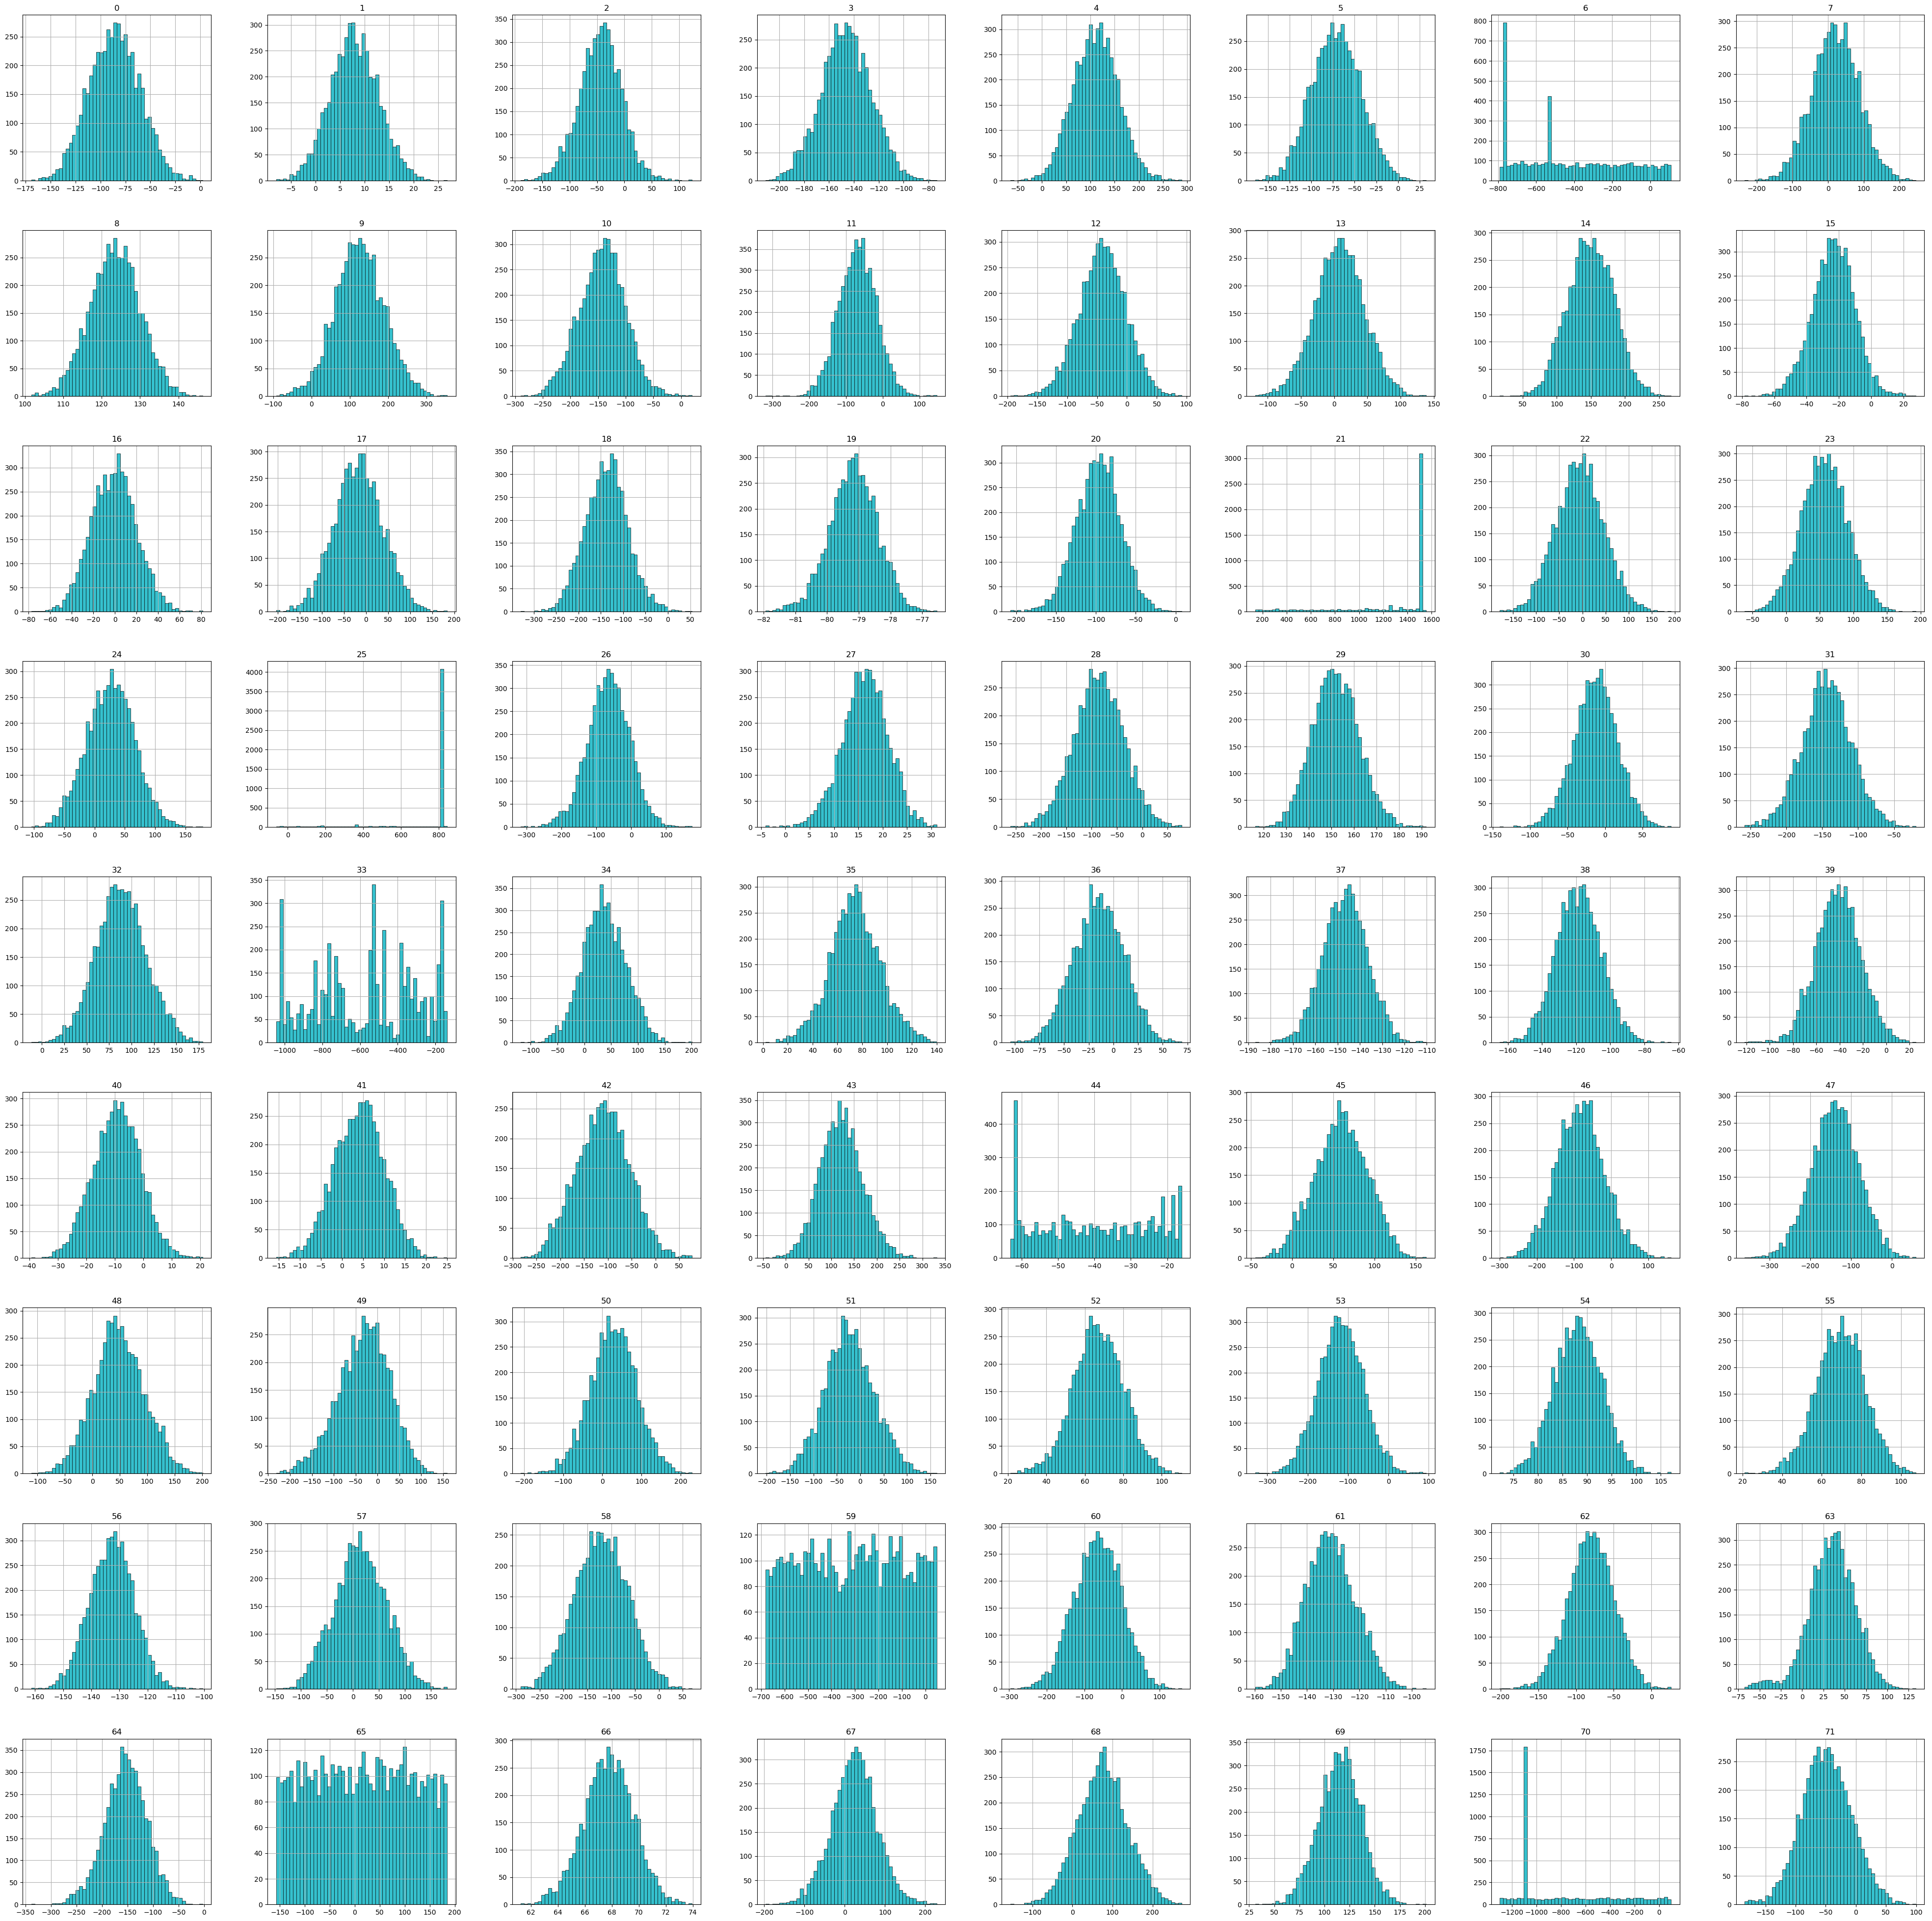

In [11]:
mini_base.hist(bins=50, figsize=(50,50), color='#35c0cd', edgecolor='black', linewidth=0.5)
plt.show()

Пропущенные значения и дубликаты в данных не обнаружены. Большая часть данных имеет нормальное распределение, есть данные с более или менее равномерным распределением, но также есть несбалансированные данные с пиковыми "хвостами". Проверим данные на корреляцию, мультиколлинеарность. А также построим боксплоты, чтобы проверить признаки на выбросы.

## Корреляция и мультиколлинеарность

Проверим, нет ли линейных зависимостей между признаками.

In [12]:
df_base[:10000].corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,1.000000,0.007668,0.007558,-0.001432,0.028713,-0.038771,0.015343,-0.002577,-0.000210,-0.007051,0.014207,0.006317,-0.018147,0.006216,0.033415,-0.001314,0.003563,-0.027188,0.025913,0.028243,0.026479,0.026092,0.037902,-0.025164,-0.010704,0.046452,-0.014380,0.022565,0.013986,0.016016,0.003518,-0.026900,-0.003551,0.043941,0.009962,-0.004658,0.027696,-0.009762,0.002825,-0.006775,0.019929,0.000026,0.032759,0.013994,0.026258,0.034979,-0.014219,0.020675,-0.023938,-0.003686,0.003404,-0.014499,0.030218,-0.018714,-0.005950,0.001934,0.019415,0.017108,-0.006451,-0.002219,0.004193,0.024964,-0.011042,0.030330,0.024424,-0.001012,-0.018651,-0.005018,-0.009961,-0.022696,-0.025845,0.012698
1,0.007668,1.000000,-0.001109,-0.011327,-0.008541,0.022366,0.023155,0.028961,0.017596,-0.016545,-0.050902,-0.024779,-0.001055,0.023852,-0.048959,0.024378,0.054057,-0.023013,0.017101,0.003133,-0.025935,0.008986,-0.033431,0.012185,0.056880,0.001113,-0.014619,0.004025,0.018099,-0.018168,0.018343,0.004691,-0.024965,0.027012,-0.027219,0.078196,-0.037629,-0.011089,-0.003922,0.006588,-0.016498,-0.017947,-0.029550,-0.016818,0.051834,0.019793,0.007566,-0.001083,0.035910,0.006771,-0.010346,0.003083,0.000222,0.005339,0.000959,0.029098,-0.029429,-0.057059,-0.028892,-0.017024,-0.029545,-0.024041,-0.011132,-0.114701,0.002017,-0.003056,0.058070,0.009124,-0.007086,0.020329,-0.007661,-0.007406
2,0.007558,-0.001109,1.000000,0.003009,0.009276,-0.029793,-0.008131,-0.007895,0.005992,0.006666,0.001201,-0.030688,-0.008033,0.002894,0.000010,0.006827,0.012445,0.004578,-0.001325,-0.019151,0.010324,0.025161,-0.012304,-0.028752,-0.011765,0.021138,-0.000768,-0.006740,-0.004161,-0.009371,-0.006400,-0.008737,-0.002448,-0.007323,-0.026233,0.024300,-0.026043,-0.028171,0.028135,-0.017060,-0.010023,-0.019593,0.008046,-0.008956,0.003844,0.023959,0.003752,-0.019464,0.035272,-0.032846,0.027801,-0.015649,0.020254,0.003467,-0.011548,0.031885,0.018942,0.001686,0.017031,0.003550,-0.028768,-0.035583,-0.014671,-0.010671,0.009933,0.015585,-0.030875,-0.019566,-0.049451,0.022289,0.002427,-0.038951
3,-0.001432,-0.011327,0.003009,1.000000,-0.004865,-0.017147,-0.011405,0.007026,-0.013061,-0.005012,0.013688,-0.002502,-0.015888,-0.013269,0.000003,-0.006389,-0.000156,0.003944,0.004003,-0.003076,0.021157,-0.002486,0.036155,-0.006430,0.018343,-0.014624,-0.009728,-0.031586,0.012386,0.010923,0.001307,0.005386,0.017122,-0.002403,0.011815,-0.010599,0.016087,0.016966,-0.011016,-0.017638,0.035473,0.005145,0.020741,0.012960,-0.004734,-0.015311,-0.002667,-0.015268,-0.011868,0.022603,-0.013655,0.011864,-0.024852,-0.011602,0.004894,0.021437,-0.016208,0.043233,0.003102,-0.005933,0.020259,0.002742,-0.018188,0.032172,-0.014058,0.000234,-0.016411,0.010624,0.035678,-0.011191,-0.005717,-0.016498
4,0.028713,-0.008541,0.009276,-0.004865,1.000000,0.010592,0.004825,-0.018473,-0.013797,0.022415,0.015667,-0.029058,-0.000249,0.015717,-0.018978,-0.017138,-0.019402,0.004278,0.010496,0.005573,0.027869,-0.006954,0.005088,-0.012782,-0.010490,0.012977,-0.032401,0.003923,-0.024262,-0.030283,-0.001374,-0.021892,-0.036781,0.010357,-0.014357,0.000416,0.029562,0.030398,0.019378,0.008083,0.033336,0.005398,-0.002363,-0.010754,0.023608,0.025977,-0.018431,-0.038012,-0.005919,-0.029790,-0.036798,0.011766,-0.004435,0.019852,0.000505,0.017741,-0.020960,-0.023739,0.000077,0.018708,0.006872,-0.017353,-0.005959,-0.003361,0.014531,0.004671,0.007094,0.017039,0.002473,-0.031267,-0.013978,0.003671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-0.005018,0.009124,-0.019566,0.010624,0.017039,0.011237,0.016687,-0.017

Линейные зависимости не обнаружены. Посмотрим на мультиколлинеарность.

In [13]:
df = df_base[:5000]
X_variables = df_base[:5000]

vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

vif_data.sort_values(by='VIF', ascending=False).head(25)

,feature,VIF
19,19,2691.446522
66,66,1260.547198
8,8,358.230886
54,54,337.380566
56,56,288.956516
29,29,226.370736
37,37,225.027320
61,61,205.363323
38,38,83.707078
3,3,54.719422


Значения более 10 говорят об очень высокой мультиколлинеарности. Признаки с высокой мультиколлинеарностью могут снижать точность оценки.

## Выбросы

Для каждого признака построим пары гистограмма+боксплот, чтобы подробнее изучить распределения и выявить выбросы.

In [14]:
mini_df_base = df_base[:10000]

In [15]:
def two_graf(data_train, name, bins):
    print()
    print('\033[1m' + f'Описание признака {name}:' + '\033[0m')
    print(data_train.describe())
    
    plt.suptitle(f'ГИСТОГРАММА И БОКСПЛОТ ДЛЯ ПРИЗНАКА {name}:')
    
    #Гистограмма
    plt.subplot(1, 2, 1)
    data_train.plot(
        kind='hist', 
        bins=bins, 
        grid=True, 
        figsize = (12,5),
        color = '#35c0cd',
        edgecolor='black');
    plt.ylabel('')
    plt.xlabel(f'{name} train'); 
    
    #Боксплот
    plt.subplot(1, 2, 2)
    box = plt.boxplot(
        x=data_train, vert=True, widths=0.5,
        patch_artist=True, 
        boxprops = dict(facecolor = "#35c0cd")  
    )
    plt.show()
    
    z1 = data_train.quantile(0.25)
    z3 = data_train.quantile(0.75)
    r = z3 - z1
    lower = z1 - (1.5 * r)
    upper = z3 + (1.5 * r)
    print('\033[1m' + f'Пороговые значения признака {name}:' + '\033[0m')
    print('Нижняя граница значений:', lower.round(2))
    print('Верхняя граница значений:', upper.round(2))


Описание признака 0:
count    10000.000000
mean       -86.037514
std         25.398874
min       -172.677765
25%       -103.800947
50%        -86.008049
75%        -68.635677
max          2.192535
Name: 0, dtype: float64


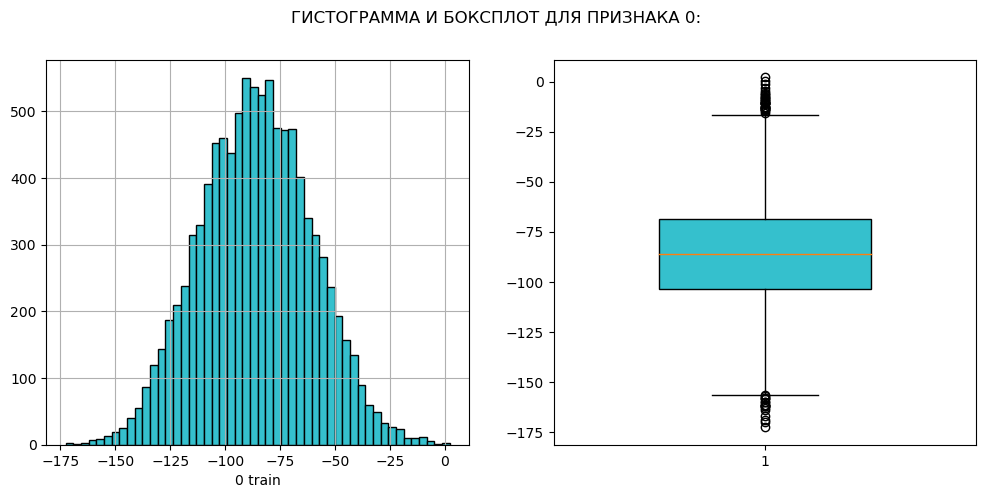

Пороговые значения признака 0:
Нижняя граница значений: -156.55
Верхняя граница значений: -15.89

Описание признака 1:
count    10000.000000
mean         7.845148
std          4.930512
min         -8.555553
25%          4.448846
50%          7.772382
75%         11.160141
max         26.869356
Name: 1, dtype: float64


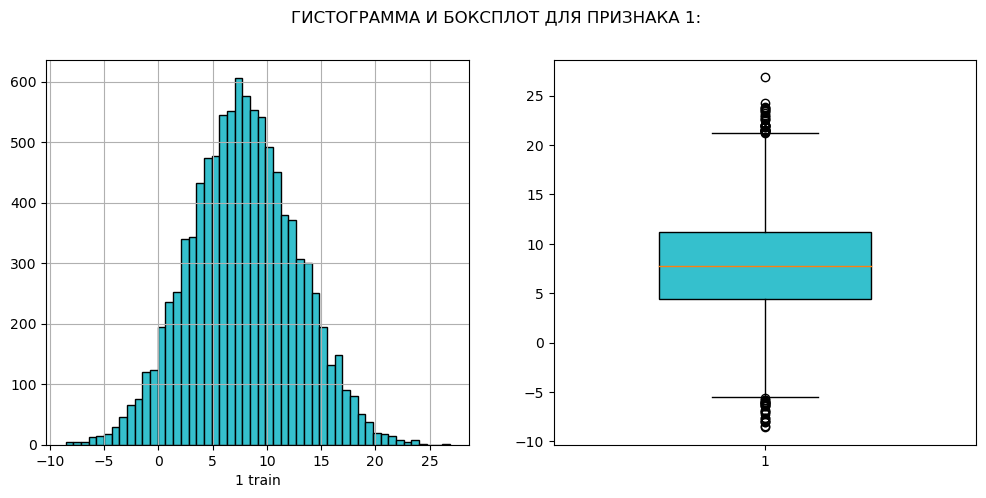

Пороговые значения признака 1:
Нижняя граница значений: -5.62
Верхняя граница значений: 21.23

Описание признака 2:
count    10000.000000
mean       -44.379597
std         38.782925
min       -227.843689
25%        -69.353979
50%        -43.591158
75%        -19.128919
max        122.970482
Name: 2, dtype: float64


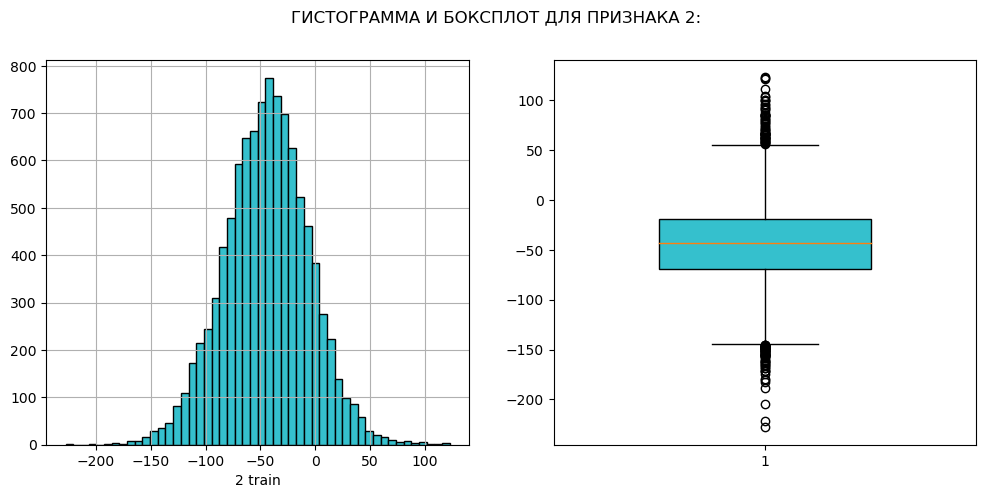

Пороговые значения признака 2:
Нижняя граница значений: -144.69
Верхняя граница значений: 56.21

Описание признака 3:
count    10000.000000
mean      -146.441483
std         20.273310
min       -212.838455
25%       -159.701473
50%       -146.509094
75%       -132.781967
max        -51.374779
Name: 3, dtype: float64


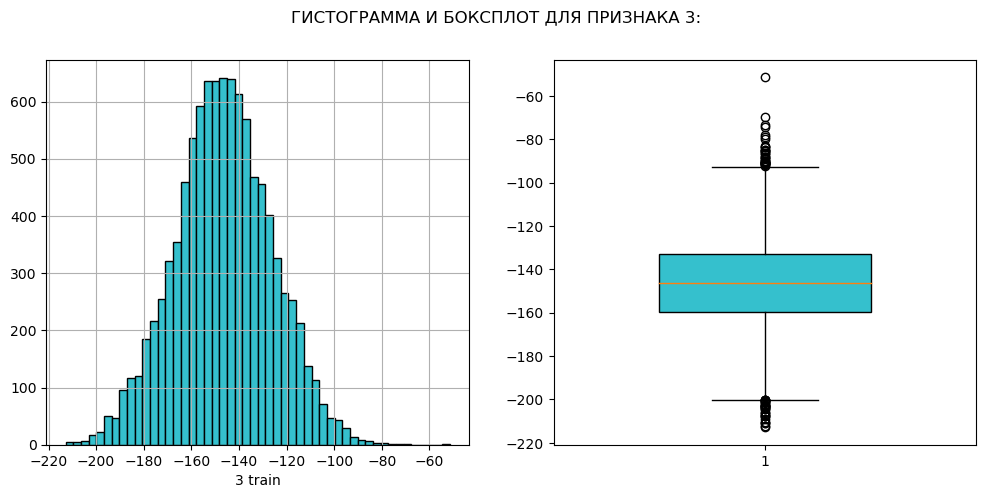

Пороговые значения признака 3:
Нижняя граница значений: -200.08
Верхняя граница значений: -92.4

Описание признака 4:
count    10000.000000
mean       111.093559
std         47.042652
min        -78.432465
25%         79.269007
50%        111.873810
75%        142.960468
max        288.235382
Name: 4, dtype: float64


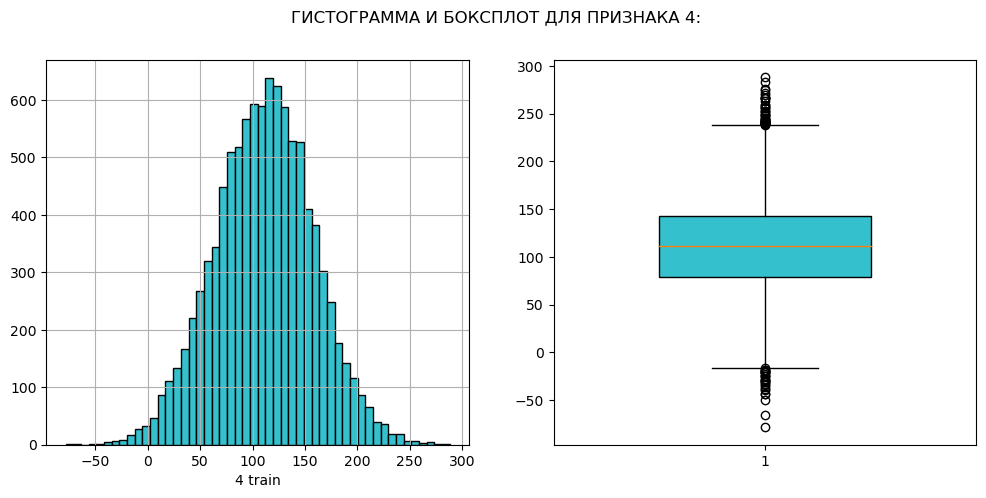

Пороговые значения признака 4:
Нижняя граница значений: -16.27
Верхняя граница значений: 238.5

Описание признака 5:
count    10000.000000
mean       -71.776772
std         28.245968
min       -173.105011
25%        -91.219368
50%        -71.953625
75%        -52.250210
max         32.596260
Name: 5, dtype: float64


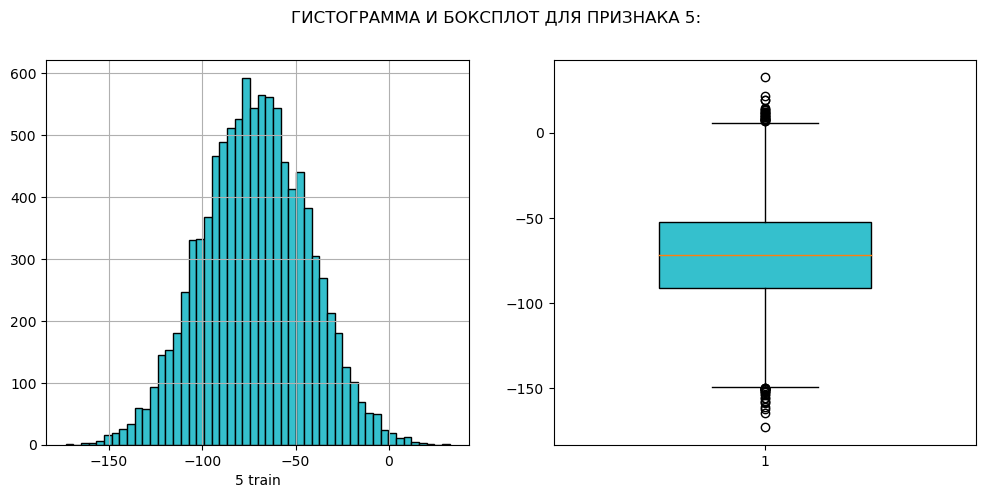

Пороговые значения признака 5:
Нижняя граница значений: -149.67
Верхняя граница значений: 6.2

Описание признака 6:
count    10000.000000
mean      -416.369659
std        275.817566
min       -790.971802
25%       -674.087708
50%       -468.424896
75%       -177.331745
max        109.632530
Name: 6, dtype: float64


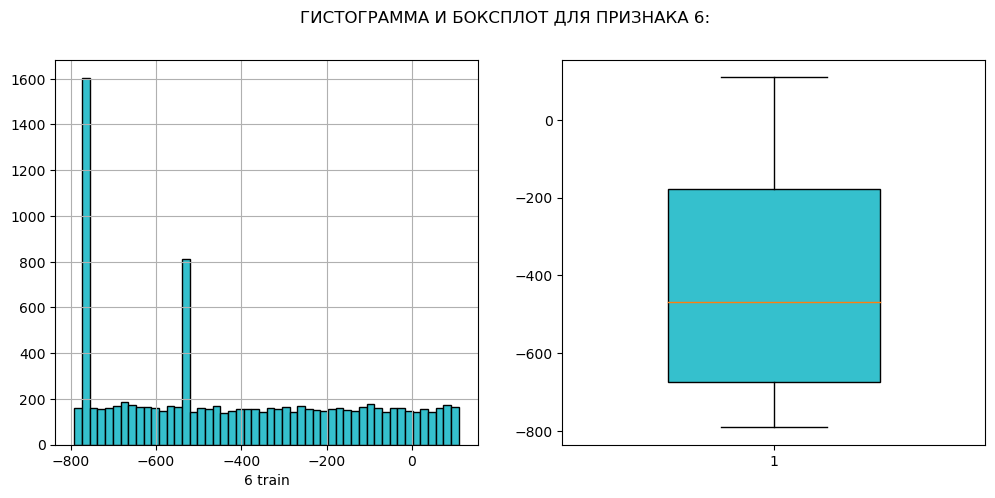

Пороговые значения признака 6:
Нижняя граница значений: -1419.22
Верхняя граница значений: 567.8

Описание признака 7:
count    10000.000000
mean        20.067129
std         65.241104
min       -249.307617
25%        -23.466406
50%         20.641233
75%         64.103495
max        297.328430
Name: 7, dtype: float64


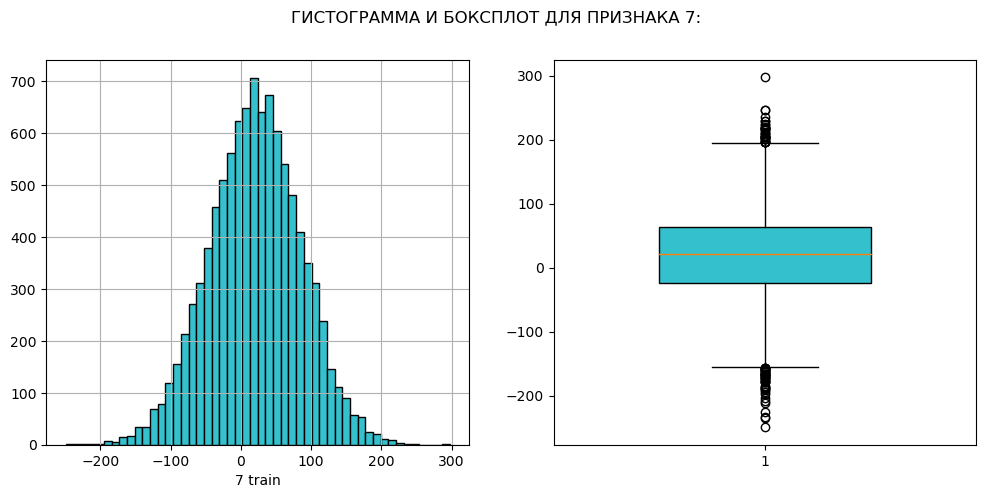

Пороговые значения признака 7:
Нижняя граница значений: -154.82
Верхняя граница значений: 195.46

Описание признака 8:
count    10000.000000
mean       123.391312
std          6.478624
min         97.489433
25%        119.114252
50%        123.453442
75%        127.804710
max        146.271637
Name: 8, dtype: float64


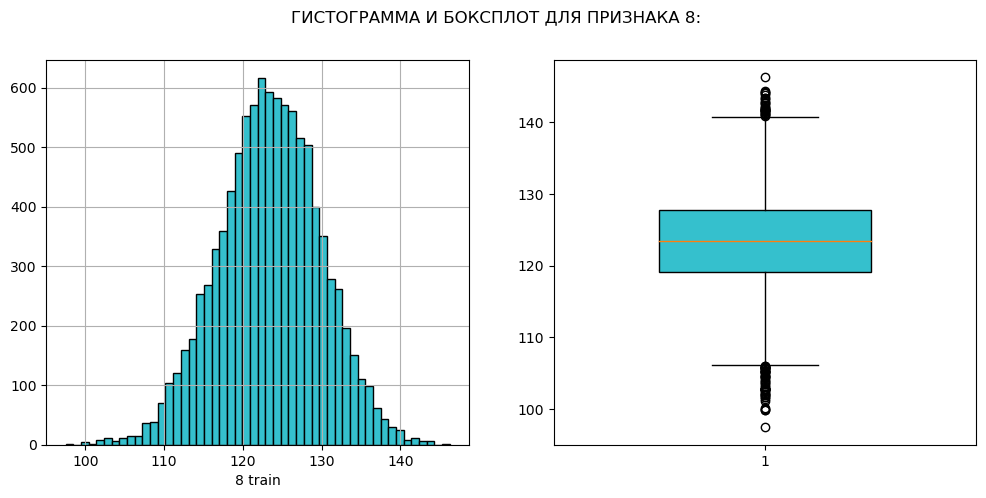

Пороговые значения признака 8:
Нижняя граница значений: 106.08
Верхняя граница значений: 140.84

Описание признака 9:
count    10000.000000
mean       125.665001
std         64.464249
min       -154.315033
25%         82.752277
50%        125.496735
75%        168.372696
max        362.742737
Name: 9, dtype: float64


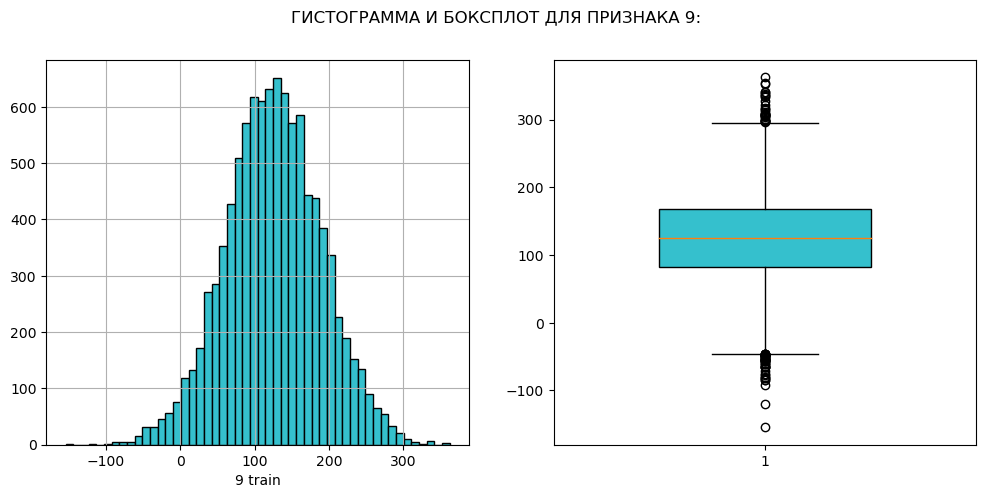

Пороговые значения признака 9:
Нижняя граница значений: -45.68
Верхняя граница значений: 296.8

Описание признака 10:
count    10000.000000
mean      -142.355316
std         41.834343
min       -300.836243
25%       -169.454269
50%       -141.296783
75%       -115.206371
max         19.777893
Name: 10, dtype: float64


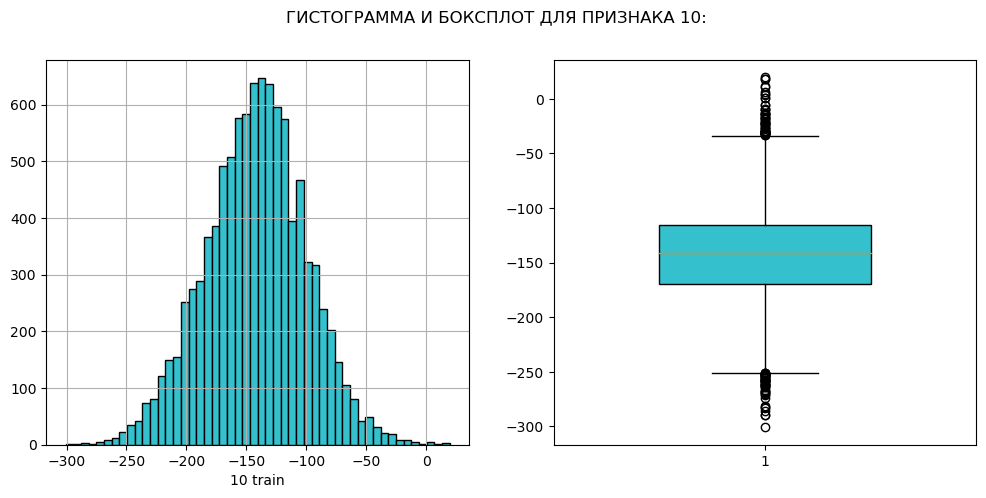

Пороговые значения признака 10:
Нижняя граница значений: -250.83
Верхняя граница значений: -33.83

Описание признака 11:
count    10000.000000
mean       -69.132797
std         51.488926
min       -318.649597
25%       -104.353670
50%        -68.595734
75%        -34.436517
max        146.553986
Name: 11, dtype: float64


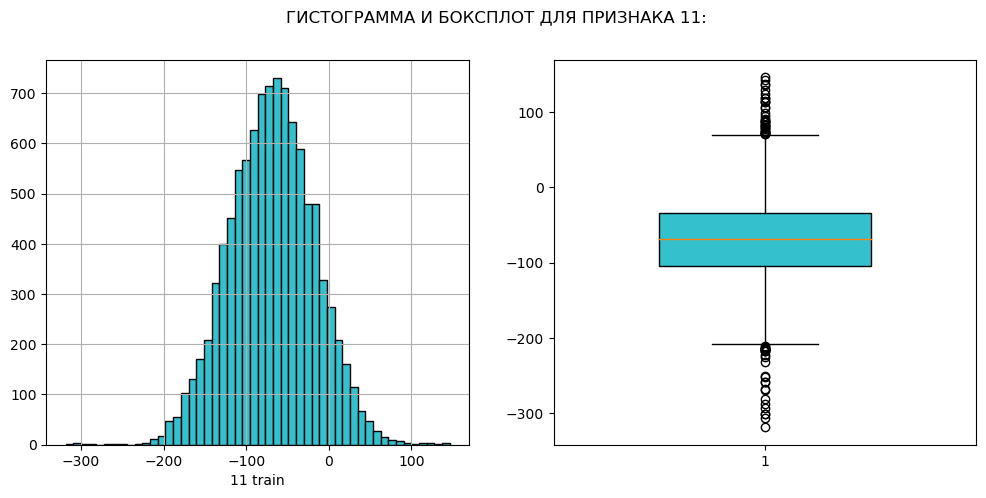

Пороговые значения признака 11:
Нижняя граница значений: -209.23
Верхняя граница значений: 70.44

Описание признака 12:
count    10000.000000
mean       -41.768894
std         39.622173
min       -195.782288
25%        -67.903137
50%        -41.359461
75%        -14.846050
max         91.292389
Name: 12, dtype: float64


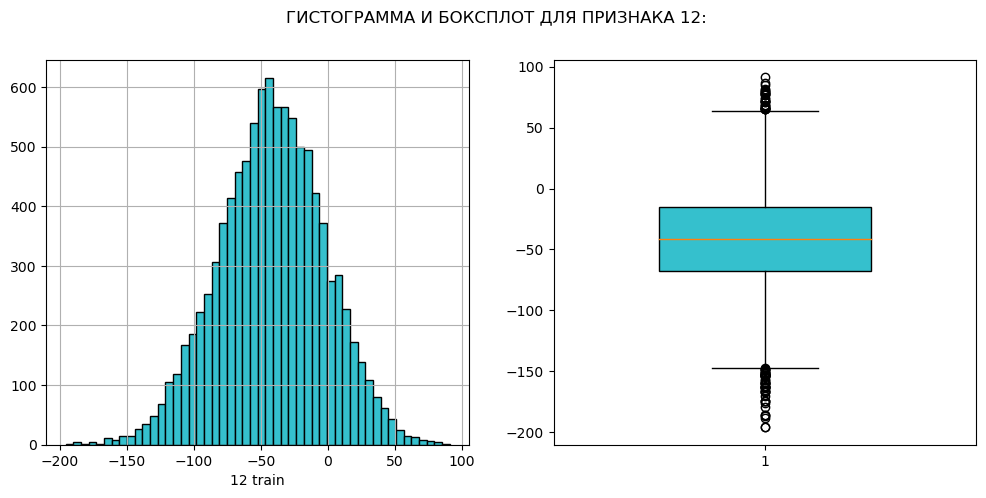

Пороговые значения признака 12:
Нижняя граница значений: -147.49
Верхняя граница значений: 64.74

Описание признака 13:
count    10000.000000
mean         7.468122
std         37.505398
min       -141.502792
25%        -17.023631
50%          8.146457
75%         32.857180
max        138.522552
Name: 13, dtype: float64


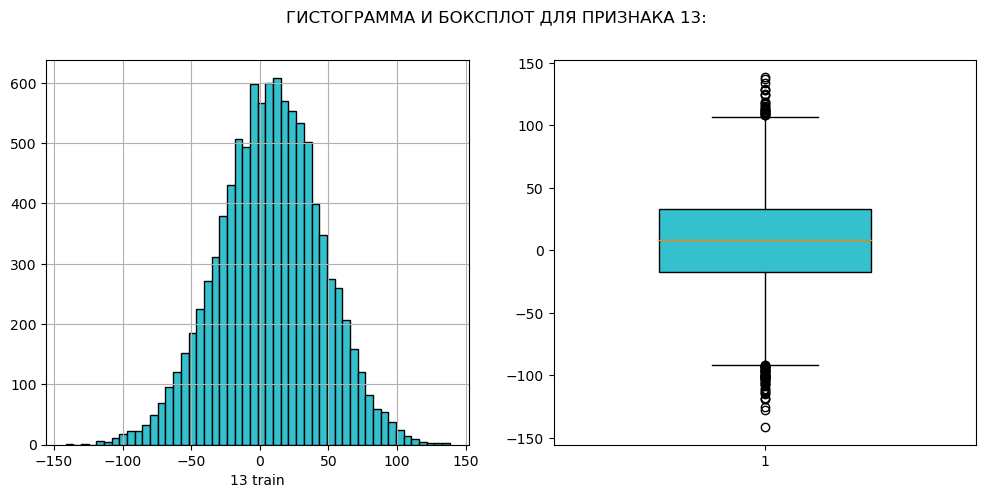

Пороговые значения признака 13:
Нижняя граница значений: -91.84
Верхняя граница значений: 107.68

Описание признака 14:
count    10000.000000
mean       149.302780
std         33.749825
min         16.418182
25%        126.631966
50%        149.466843
75%        172.875122
max        267.614075
Name: 14, dtype: float64


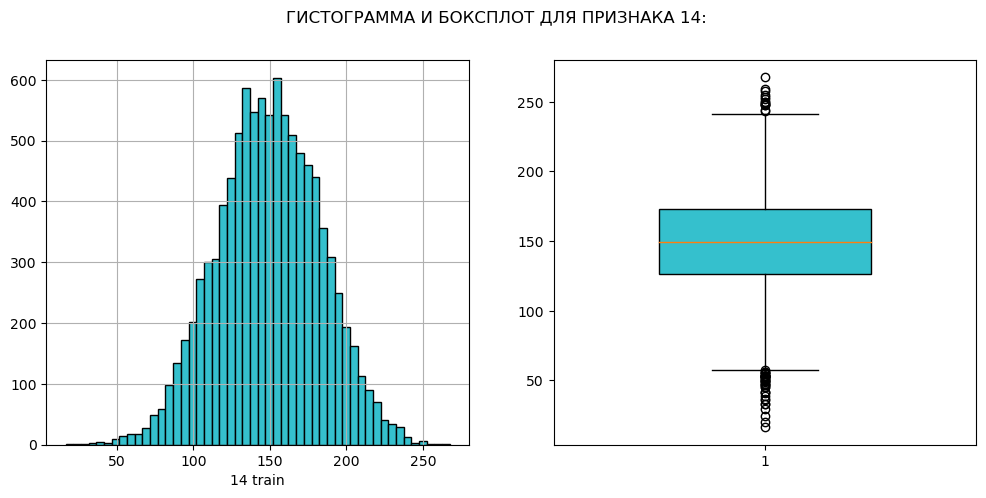

Пороговые значения признака 14:
Нижняя граница значений: 57.27
Верхняя граница значений: 242.24

Описание признака 15:
count    10000.000000
mean       -23.307985
std         13.213681
min        -78.414963
25%        -31.894218
50%        -23.128870
75%        -14.491519
max         27.732294
Name: 15, dtype: float64


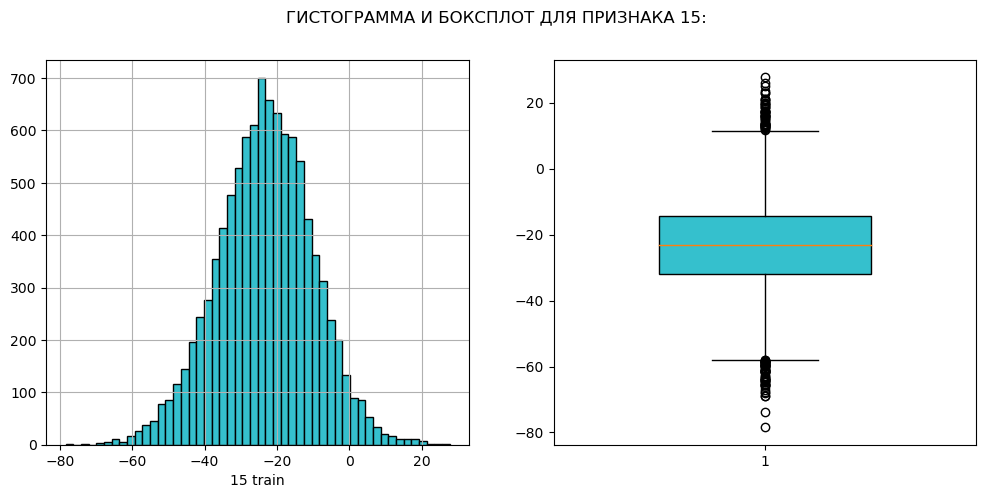

Пороговые значения признака 15:
Нижняя граница значений: -58.0
Верхняя граница значений: 11.61

Описание признака 16:
count    10000.000000
mean        -1.031402
std         20.886366
min        -77.483040
25%        -15.462107
50%         -1.125260
75%         13.096107
max         85.192337
Name: 16, dtype: float64


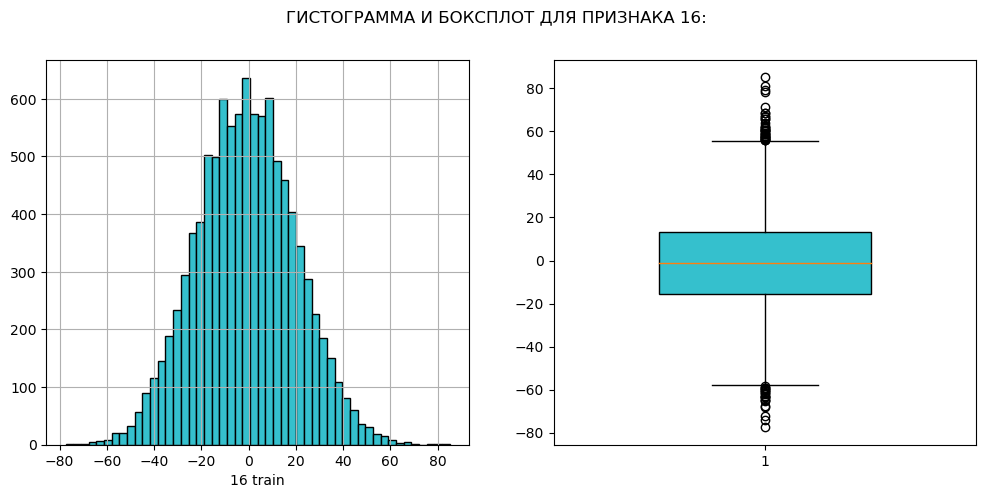

Пороговые значения признака 16:
Нижняя граница значений: -58.3
Верхняя граница значений: 55.93

Описание признака 17:
count    10000.000000
mean       -16.320587
std         54.311760
min       -216.558167
25%        -53.154722
50%        -16.021950
75%         19.868855
max        184.143066
Name: 17, dtype: float64


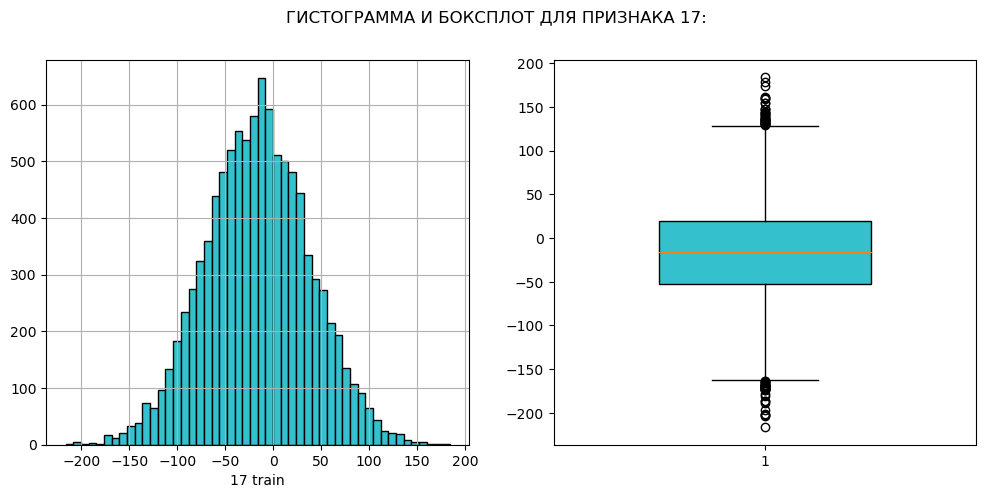

Пороговые значения признака 17:
Нижняя граница значений: -162.69
Верхняя граница значений: 129.4

Описание признака 18:
count    10000.000000
mean      -137.705856
std         47.492500
min       -334.407532
25%       -169.517746
50%       -137.616638
75%       -106.401634
max         71.750916
Name: 18, dtype: float64


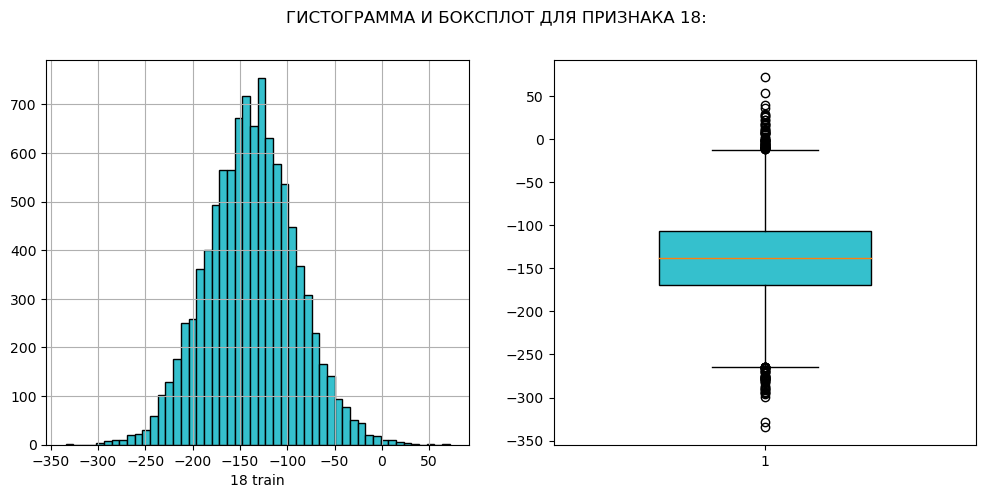

Пороговые значения признака 18:
Нижняя граница значений: -264.19
Верхняя граница значений: -11.73

Описание признака 19:
count    10000.000000
mean       -79.172966
std          0.765754
min        -81.974136
25%        -79.653406
50%        -79.160095
75%        -78.665400
max        -76.539429
Name: 19, dtype: float64


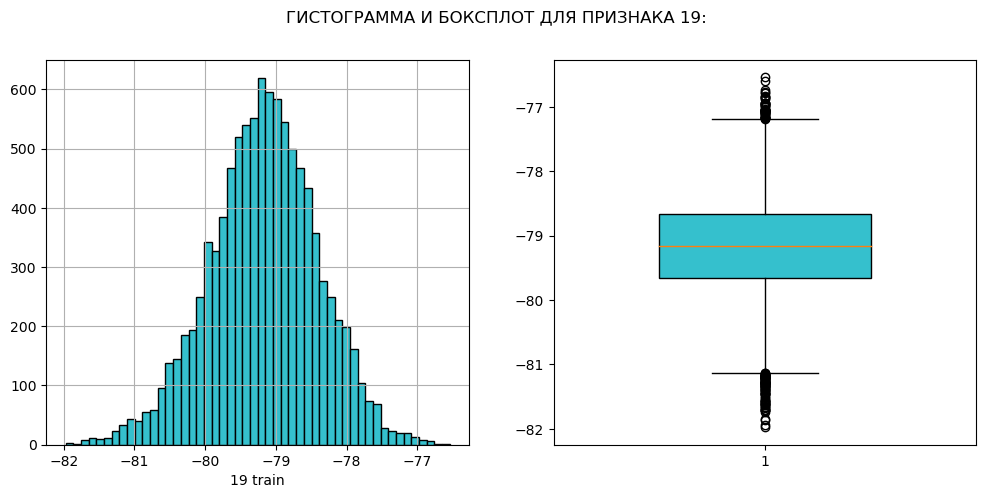

Пороговые значения признака 19:
Нижняя граница значений: -81.14
Верхняя граница значений: -77.18

Описание признака 20:
count    10000.000000
mean       -97.764709
std         27.952974
min       -216.444229
25%       -116.100809
50%        -97.235016
75%        -79.000954
max          7.300850
Name: 20, dtype: float64


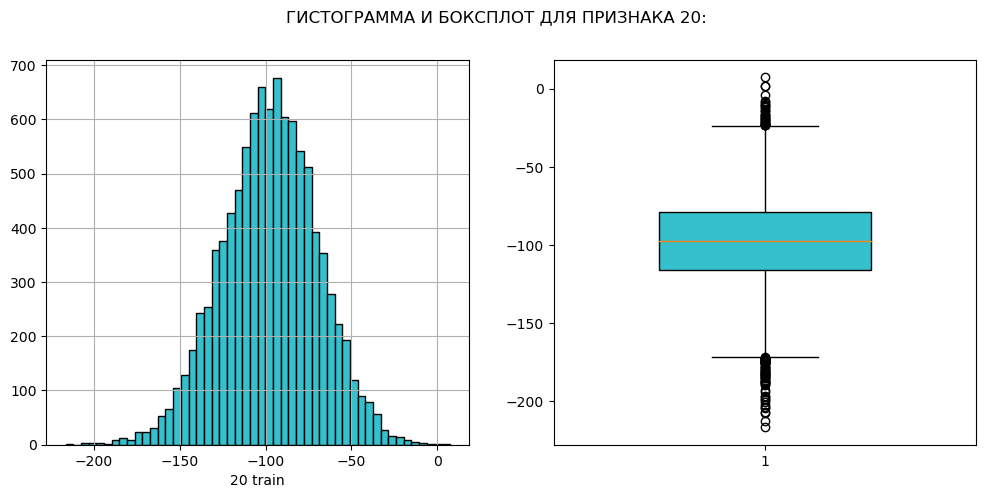

Пороговые значения признака 20:
Нижняя граница значений: -171.75
Верхняя граница значений: -23.35

Описание признака 21:
count    10000.000000
mean      1271.882568
std        391.536530
min        137.888489
25%       1145.048462
50%       1507.231323
75%       1507.231323
max       1556.220581
Name: 21, dtype: float64


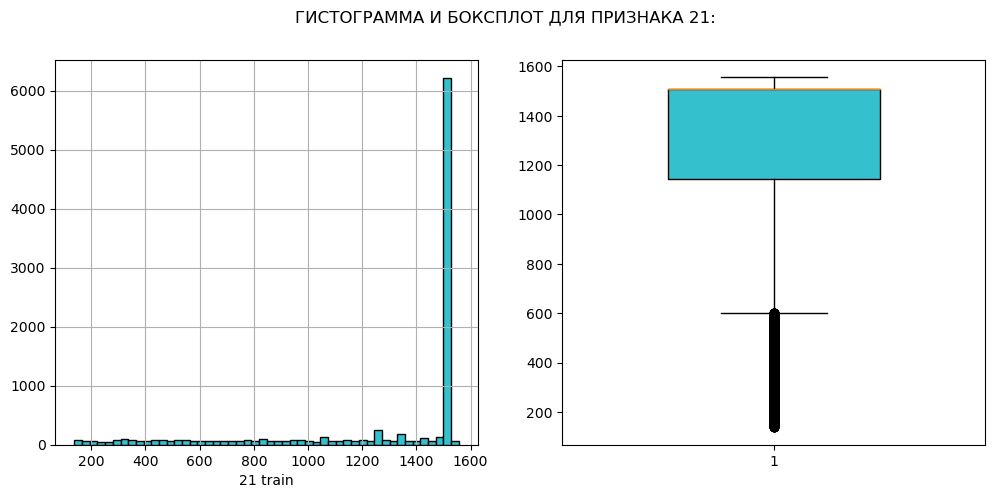

Пороговые значения признака 21:
Нижняя граница значений: 601.77
Верхняя граница значений: 2050.51

Описание признака 22:
count    10000.000000
mean        -5.906884
std         51.472733
min       -178.684753
25%        -40.660016
50%         -5.903232
75%         28.478417
max        193.053741
Name: 22, dtype: float64


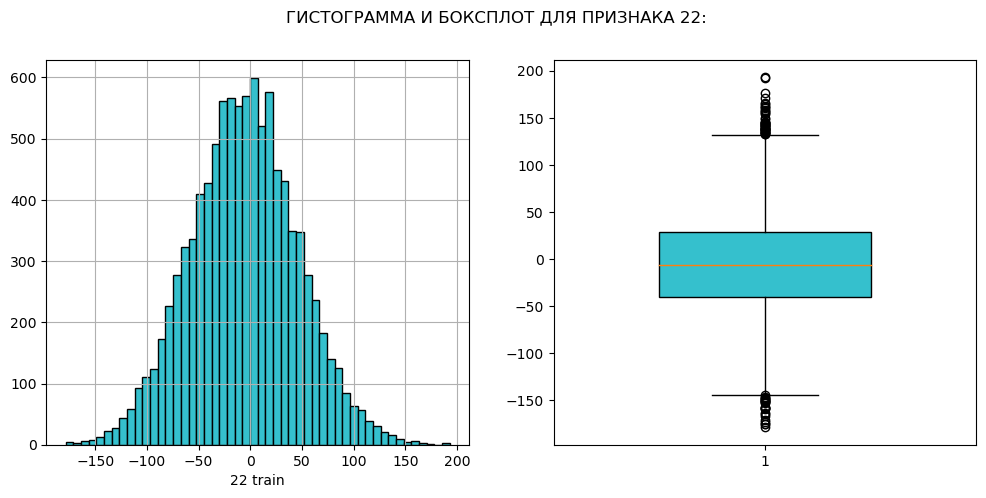

Пороговые значения признака 22:
Нижняя граница значений: -144.37
Верхняя граница значений: 132.19

Описание признака 23:
count    10000.000000
mean        56.655556
std         34.506962
min        -83.805832
25%         32.941336
50%         56.914438
75%         80.005474
max        192.781982
Name: 23, dtype: float64


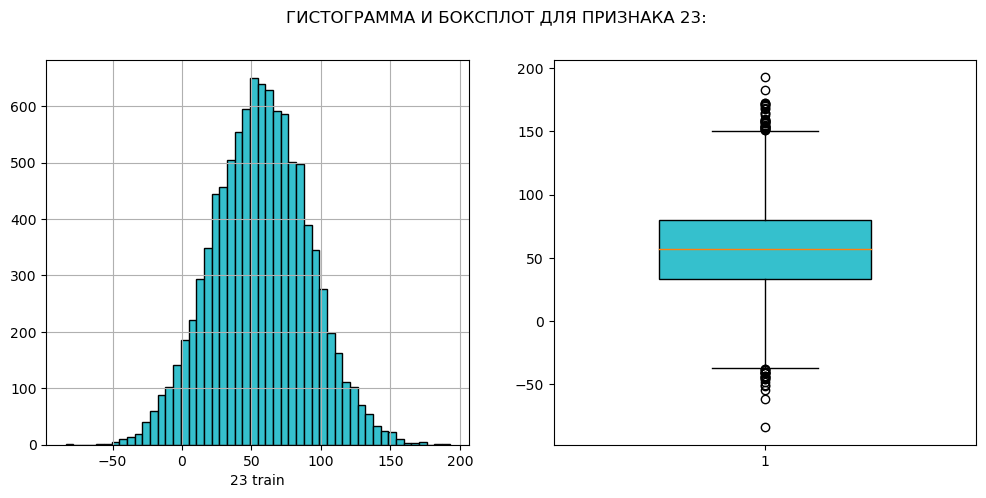

Пороговые значения признака 23:
Нижняя граница значений: -37.65
Верхняя граница значений: 150.6

Описание признака 24:
count    10000.000000
mean        25.734257
std         39.779507
min       -115.923782
25%         -1.223627
50%         26.292131
75%         52.889653
max        178.390701
Name: 24, dtype: float64


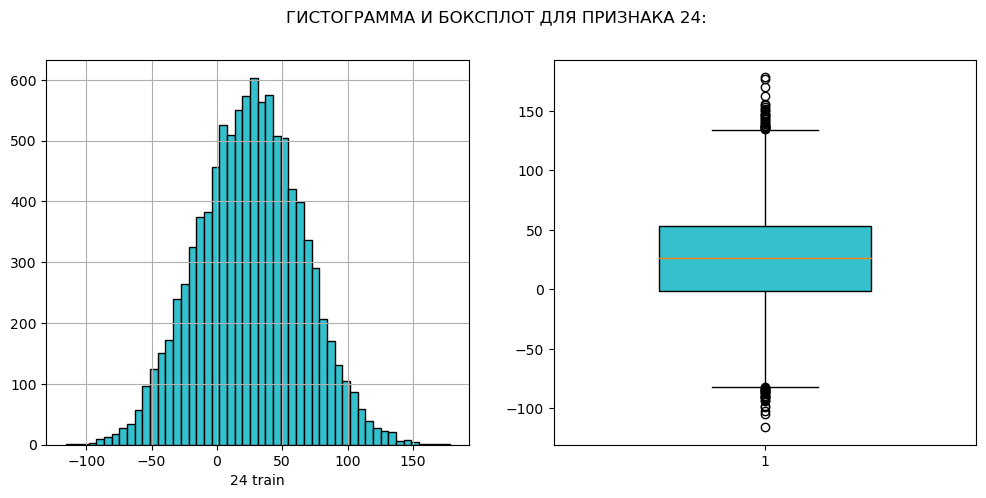

Пороговые значения признака 24:
Нижняя граница значений: -82.39
Верхняя граница значений: 134.06

Описание признака 25:
count    10000.000000
mean       733.080627
std        200.431473
min        -61.797569
25%        813.770081
50%        813.770081
75%        813.770081
max        845.159973
Name: 25, dtype: float64


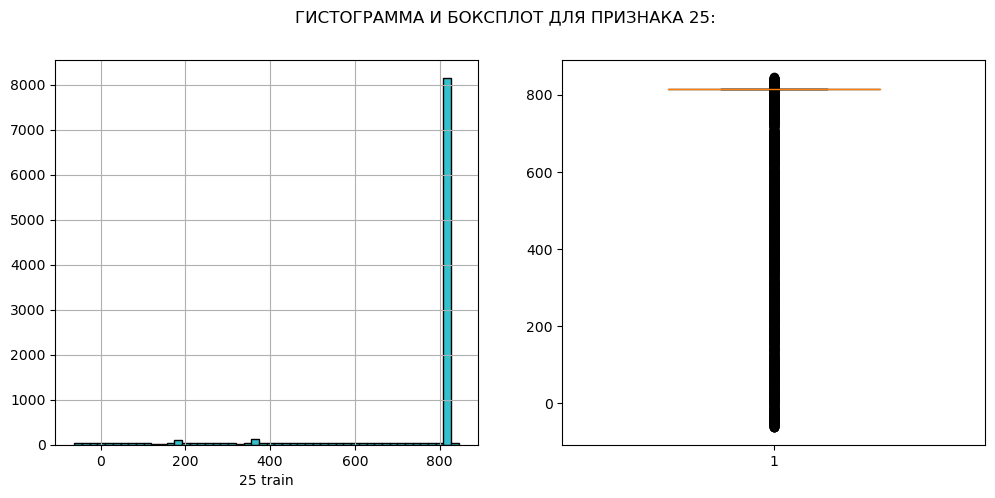

Пороговые значения признака 25:
Нижняя граница значений: 813.77
Верхняя граница значений: 813.77

Описание признака 26:
count    10000.000000
mean       -64.890976
std         61.165600
min       -315.751251
25%       -105.012133
50%        -64.275040
75%        -24.327630
max        174.184433
Name: 26, dtype: float64


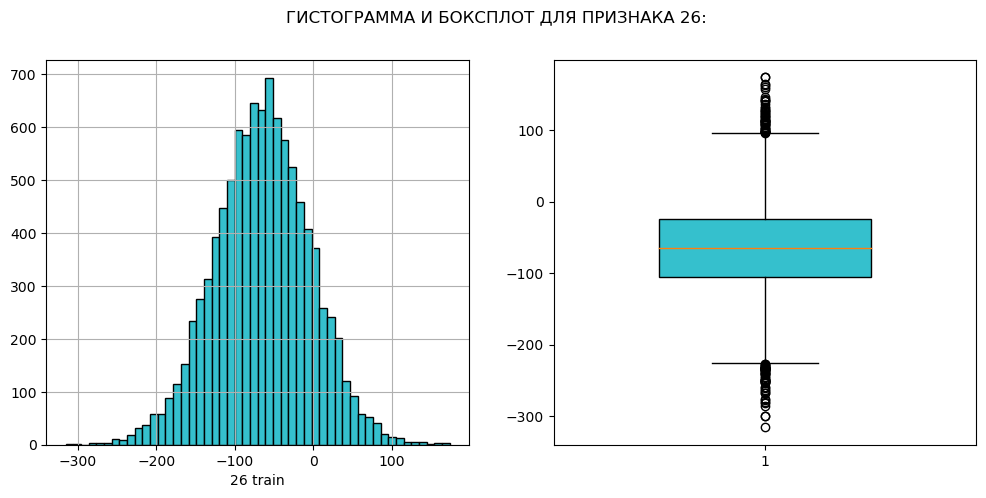

Пороговые значения признака 26:
Нижняя граница значений: -226.04
Верхняя граница значений: 96.7

Описание признака 27:
count    10000.000000
mean        16.315168
std          4.701207
min         -5.009233
25%         13.288112
50%         16.416684
75%         19.492244
max         32.765434
Name: 27, dtype: float64


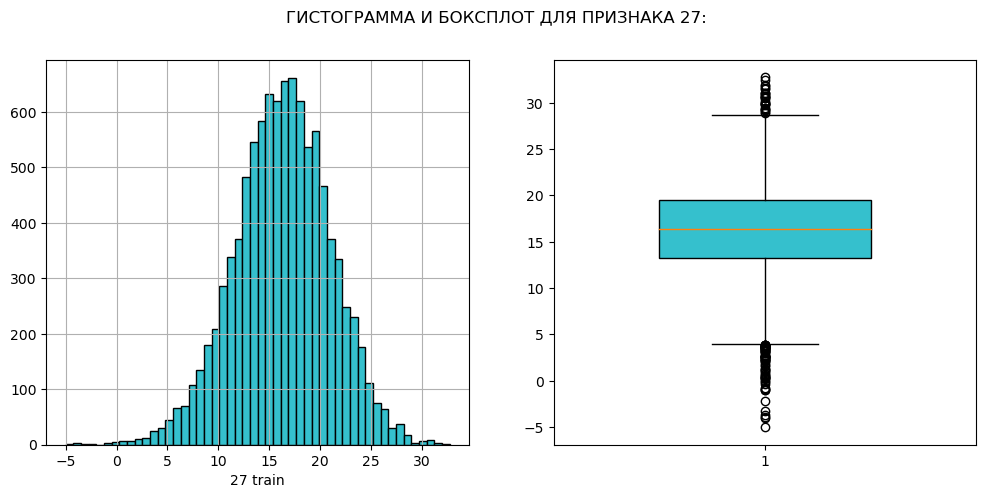

Пороговые значения признака 27:
Нижняя граница значений: 3.98
Верхняя граница значений: 28.8

Описание признака 28:
count    10000.000000
mean       -86.276535
std         49.380356
min       -271.226776
25%       -118.891973
50%        -85.618282
75%        -53.790907
max        108.579041
Name: 28, dtype: float64


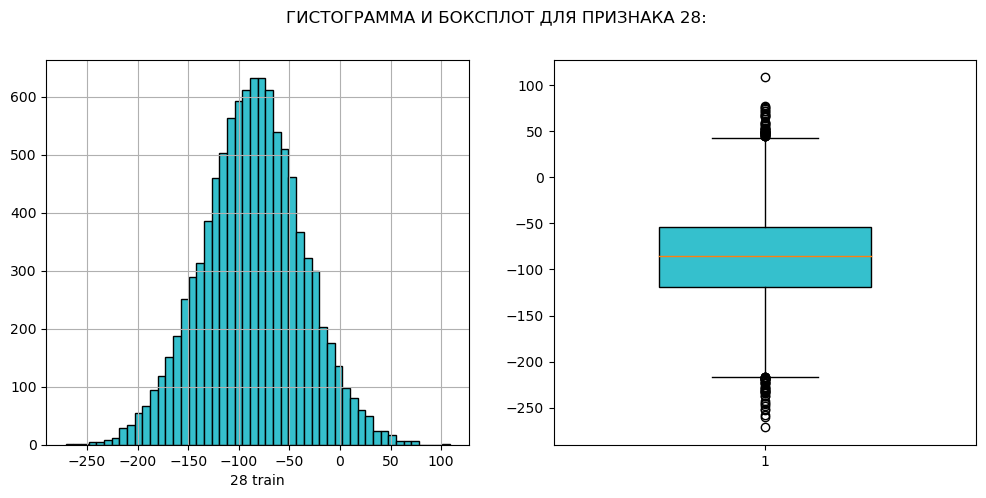

Пороговые значения признака 28:
Нижняя граница значений: -216.54
Верхняя граница значений: 43.86

Описание признака 29:
count    10000.000000
mean       151.940994
std         10.221895
min        114.211960
25%        145.020588
50%        151.764763
75%        158.697098
max        192.109528
Name: 29, dtype: float64


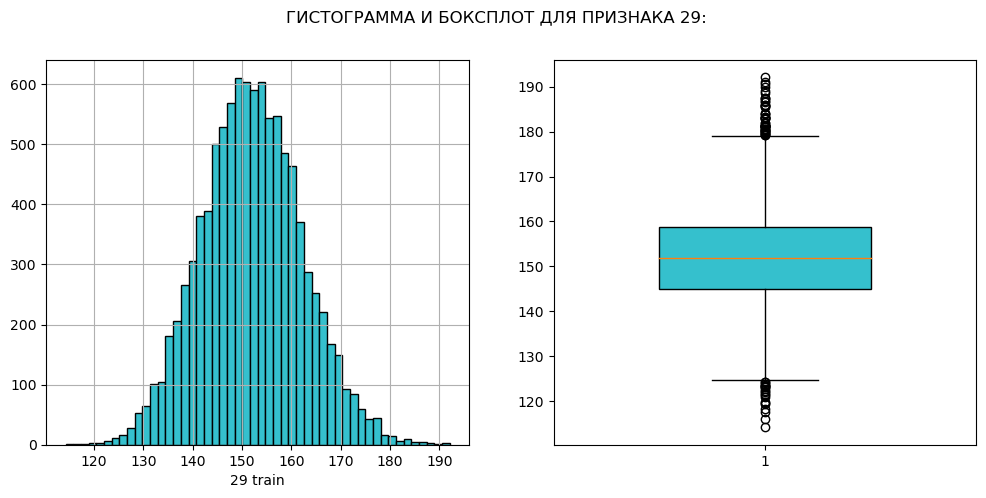

Пороговые значения признака 29:
Нижняя граница значений: 124.51
Верхняя граница значений: 179.21

Описание признака 30:
count    10000.000000
mean       -12.430273
std         29.085924
min       -140.296768
25%        -31.614142
50%        -11.934441
75%          6.966869
max         88.096863
Name: 30, dtype: float64


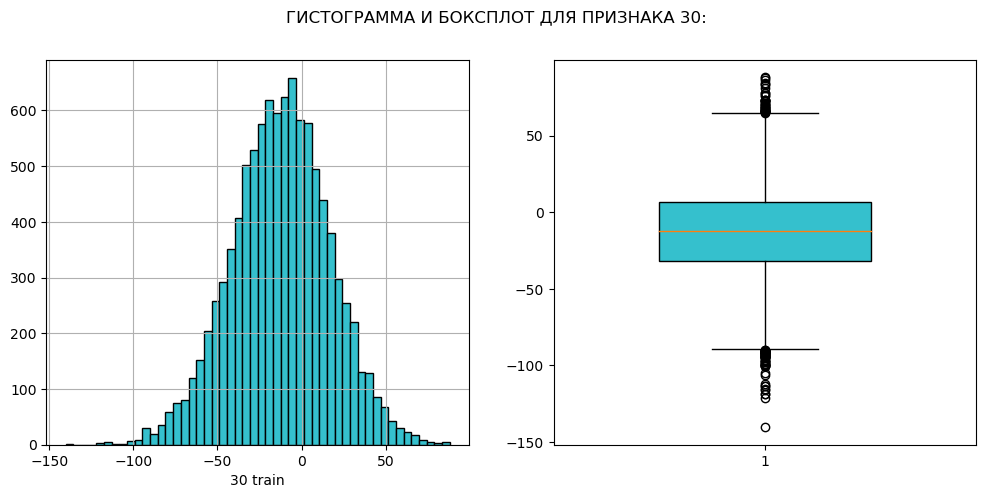

Пороговые значения признака 30:
Нижняя граница значений: -89.49
Верхняя граница значений: 64.84

Описание признака 31:
count    10000.000000
mean      -144.134766
std         35.192932
min       -273.670715
25%       -166.608742
50%       -144.190727
75%       -121.479071
max         -7.993271
Name: 31, dtype: float64


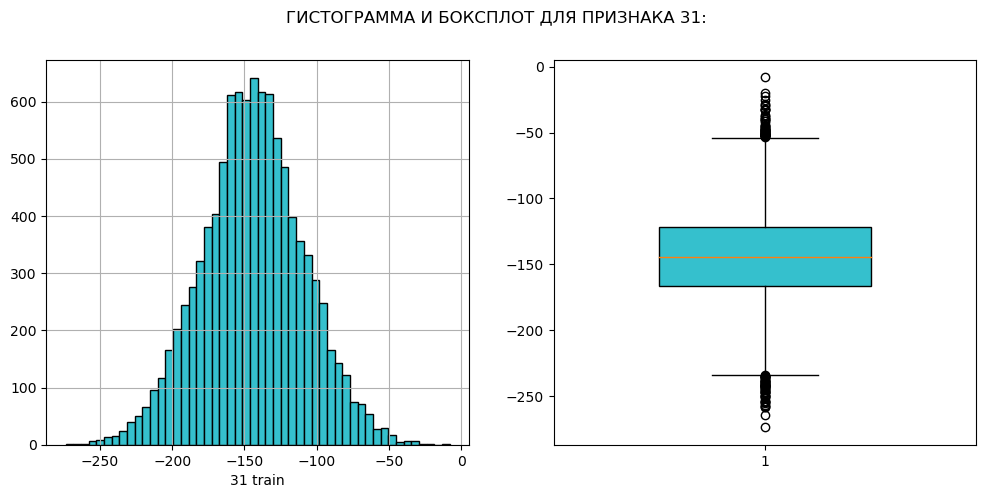

Пороговые значения признака 31:
Нижняя граница значений: -234.3
Верхняя граница значений: -53.78

Описание признака 32:
count    10000.000000
mean        87.994644
std         28.088669
min        -17.741798
25%         69.000319
50%         87.712406
75%        106.652929
max        199.120667
Name: 32, dtype: float64


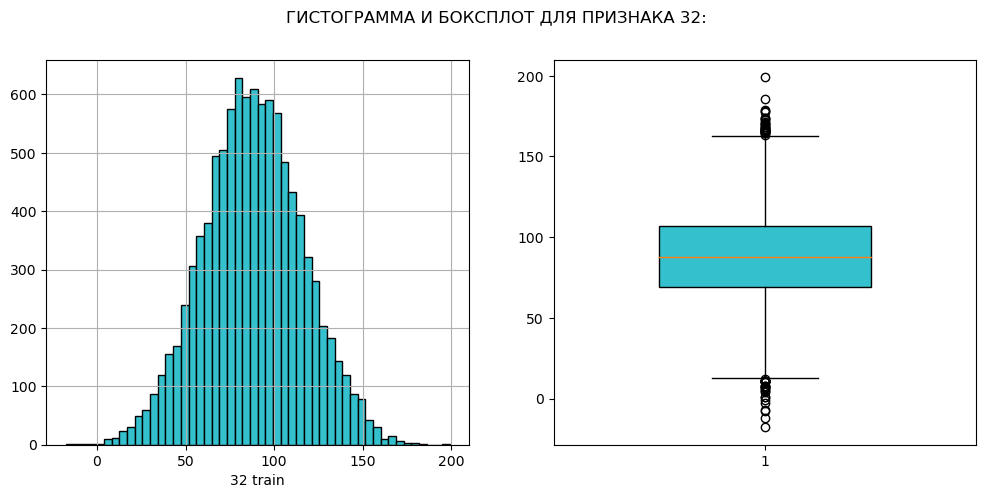

Пороговые значения признака 32:
Нижняя граница значений: 12.52
Верхняя граница значений: 163.13

Описание признака 33:
count    10000.000000
mean      -566.194885
std        266.815582
min      -1044.466309
25%       -780.449158
50%       -529.295044
75%       -341.781830
max       -137.646759
Name: 33, dtype: float64


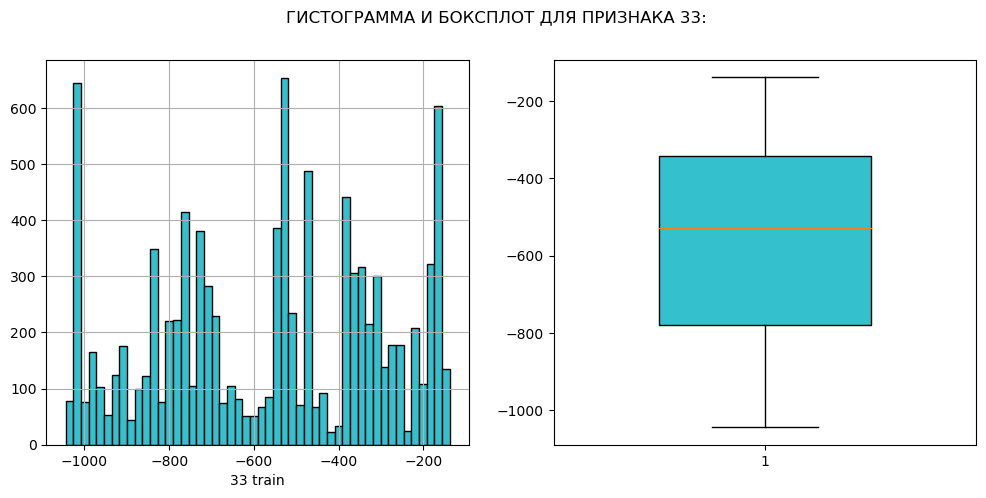

Пороговые значения признака 33:
Нижняя граница значений: -1438.45
Верхняя граница значений: 316.22

Описание признака 34:
count    10000.000000
mean        36.890579
std         39.822979
min       -118.152176
25%          9.761708
50%         36.206192
75%         63.539516
max        200.743561
Name: 34, dtype: float64


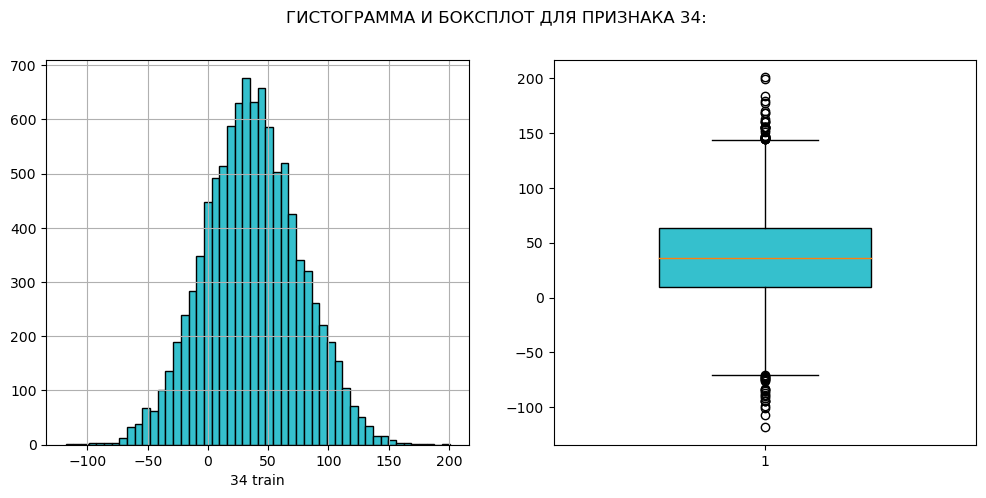

Пороговые значения признака 34:
Нижняя граница значений: -70.91
Верхняя граница значений: 144.21

Описание признака 35:
count    10000.000000
mean        74.371002
std         20.669071
min          2.086922
25%         60.715434
50%         74.110878
75%         87.867739
max        149.630615
Name: 35, dtype: float64


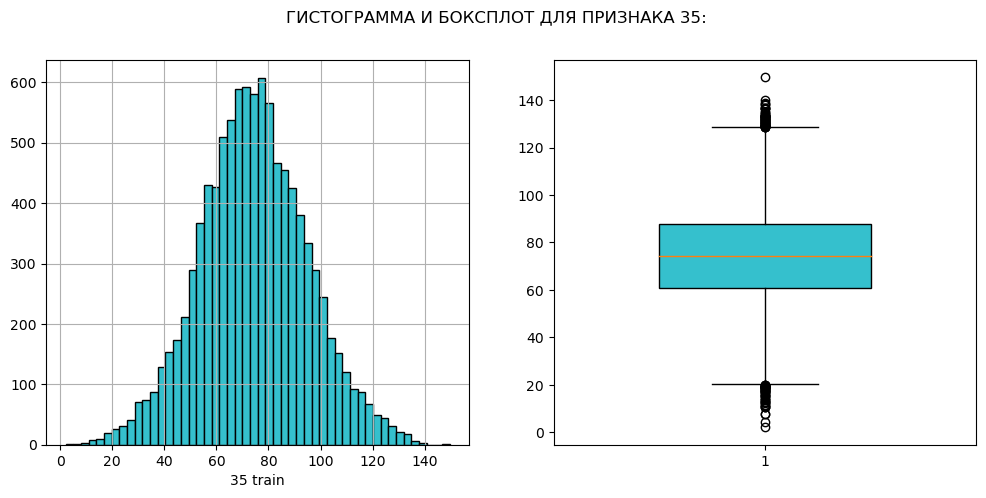

Пороговые значения признака 35:
Нижняя граница значений: 19.99
Верхняя граница значений: 128.6

Описание признака 36:
count    10000.000000
mean       -15.461804
std         25.442860
min       -115.796318
25%        -32.788390
50%        -15.032598
75%          1.972674
max         68.939377
Name: 36, dtype: float64


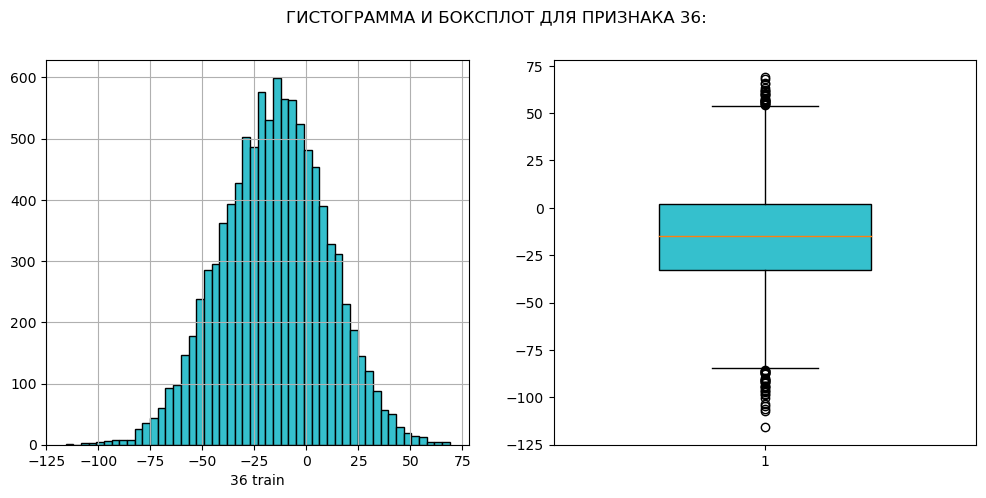

Пороговые значения признака 36:
Нижняя граница значений: -84.93
Верхняя граница значений: 54.11

Описание признака 37:
count    10000.000000
mean      -146.728653
std         10.013129
min       -187.019653
25%       -153.398247
50%       -146.735611
75%       -139.878971
max       -109.386803
Name: 37, dtype: float64


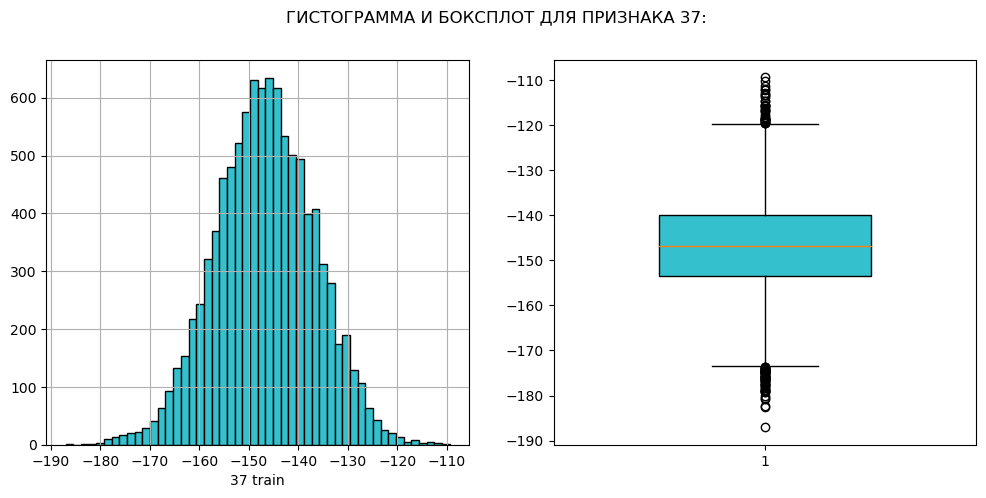

Пороговые значения признака 37:
Нижняя граница значений: -173.68
Верхняя граница значений: -119.6

Описание признака 38:
count    10000.000000
mean      -118.239326
std         13.354120
min       -166.098068
25%       -127.313284
50%       -118.249859
75%       -109.189651
max        -64.326363
Name: 38, dtype: float64


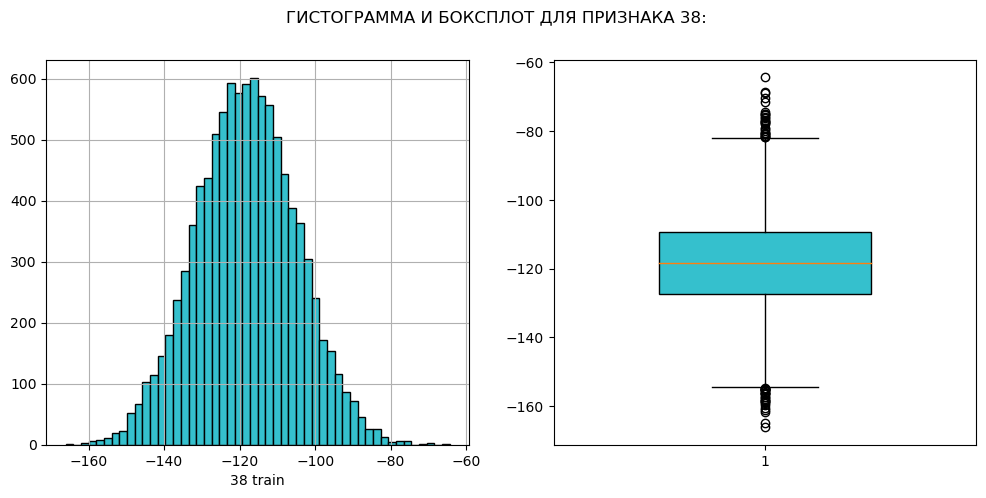

Пороговые значения признака 38:
Нижняя граница значений: -154.5
Верхняя граница значений: -82.0

Описание признака 39:
count    10000.000000
mean       -41.607563
std         19.351013
min       -121.640869
25%        -54.479926
50%        -41.759962
75%        -28.604398
max         33.504215
Name: 39, dtype: float64


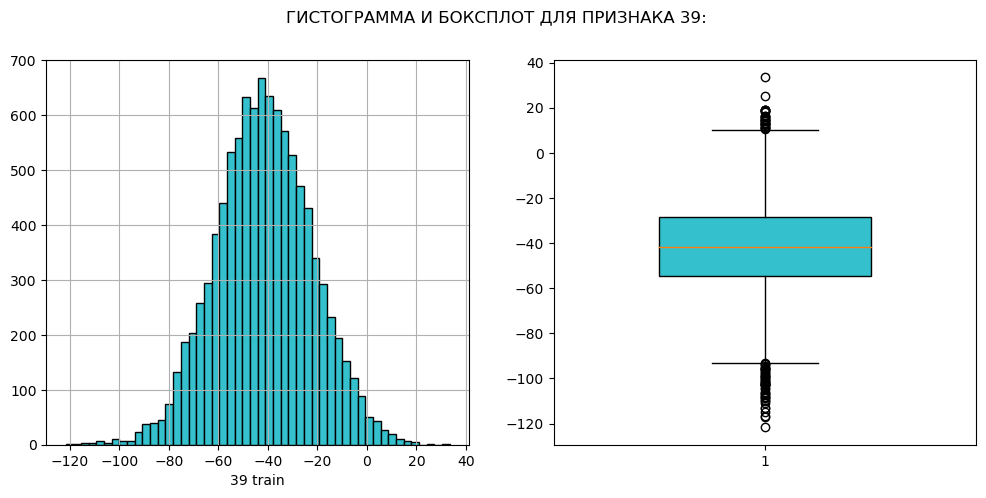

Пороговые значения признака 39:
Нижняя граница значений: -93.29
Верхняя граница значений: 10.21

Описание признака 40:
count    10000.000000
mean        -9.246939
std          8.334321
min        -39.274834
25%        -14.802635
50%         -9.209705
75%         -3.555545
max         23.067039
Name: 40, dtype: float64


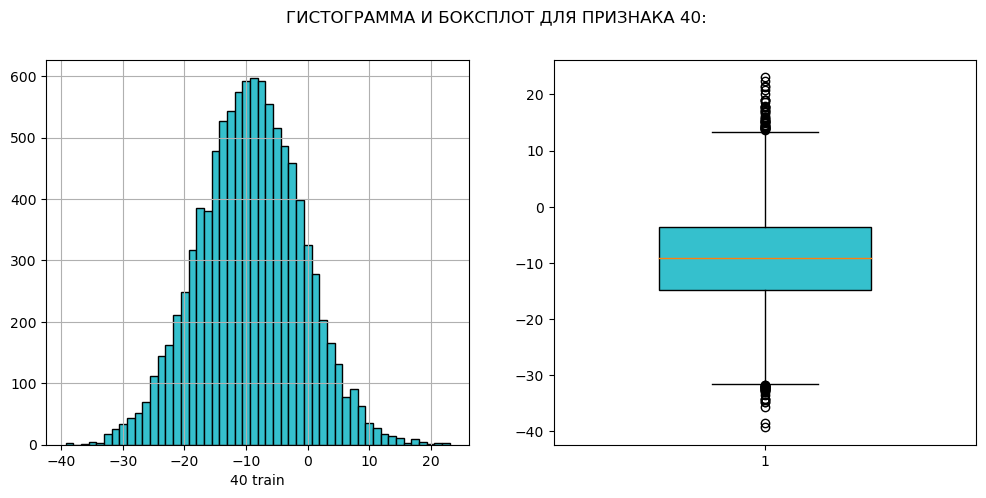

Пороговые значения признака 40:
Нижняя граница значений: -31.67
Верхняя граница значений: 13.32

Описание признака 41:
count    10000.000000
mean         4.057401
std          5.891035
min        -16.952232
25%         -0.083652
50%          4.114286
75%          8.133889
max         25.019451
Name: 41, dtype: float64


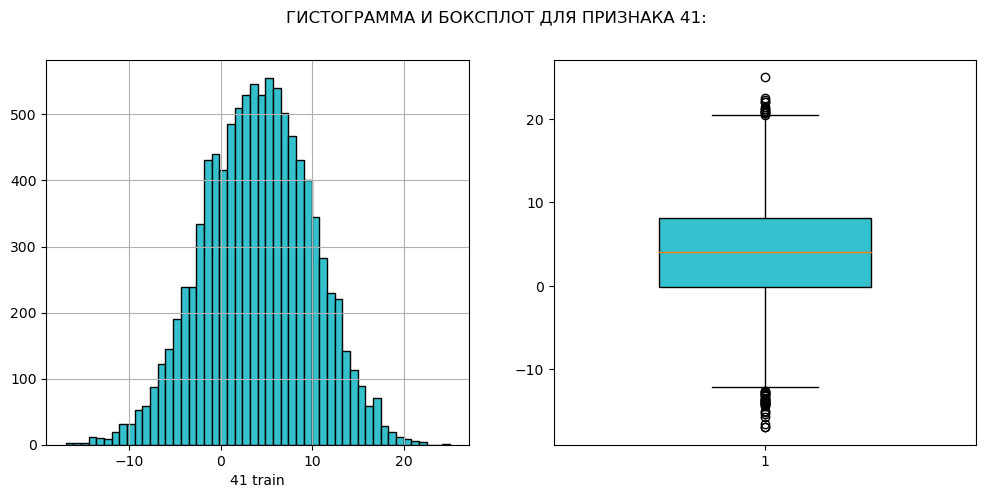

Пороговые значения признака 41:
Нижняя граница значений: -12.41
Верхняя граница значений: 20.46

Описание признака 42:
count    10000.000000
mean      -109.635834
std         56.269596
min       -284.900757
25%       -148.050797
50%       -109.373714
75%        -71.551994
max         88.636658
Name: 42, dtype: float64


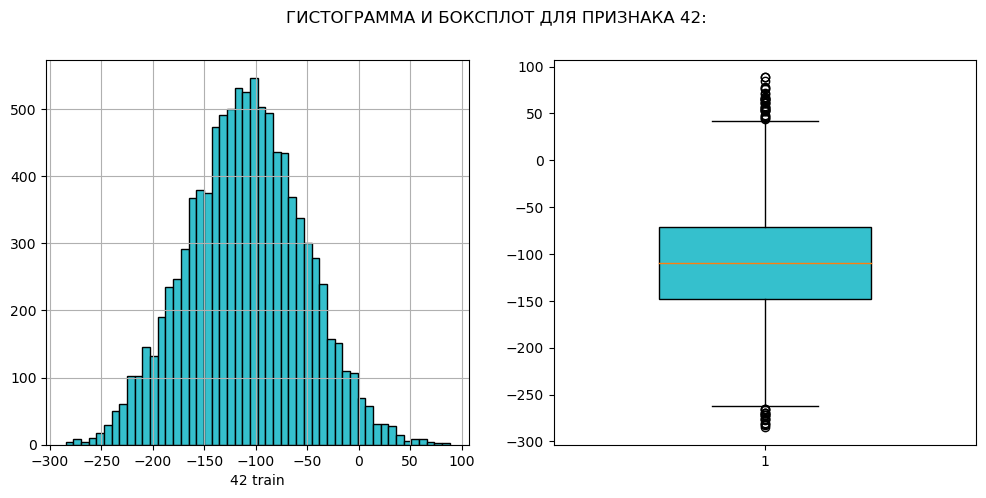

Пороговые значения признака 42:
Нижняя граница значений: -262.8
Верхняя граница значений: 43.2

Описание признака 43:
count    10000.000000
mean       121.615501
std         47.119053
min        -48.946960
25%         89.465580
50%        120.713573
75%        152.306030
max        331.507690
Name: 43, dtype: float64


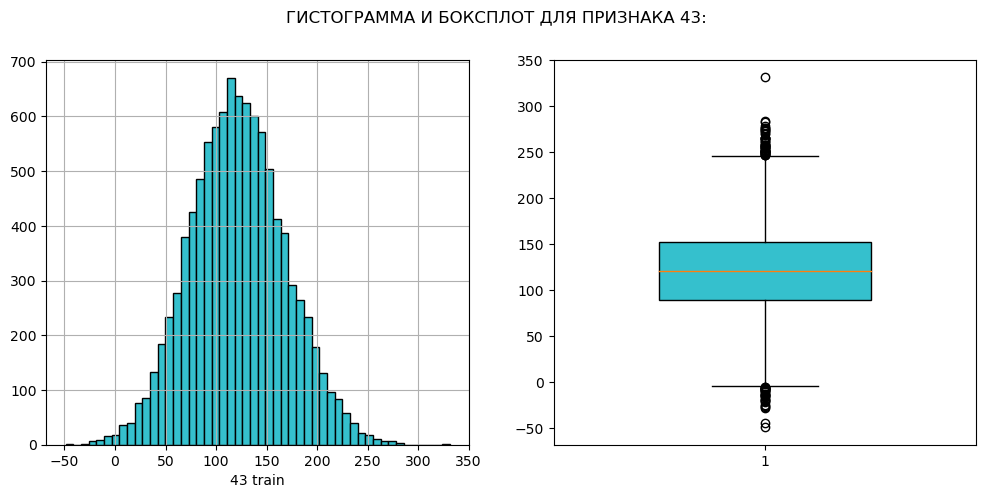

Пороговые значения признака 43:
Нижняя граница значений: -4.8
Верхняя граница значений: 246.57

Описание признака 44:
count    10000.000000
mean       -39.976002
std         14.825539
min        -63.084976
25%        -53.350853
50%        -39.983902
75%        -26.267259
max        -16.057415
Name: 44, dtype: float64


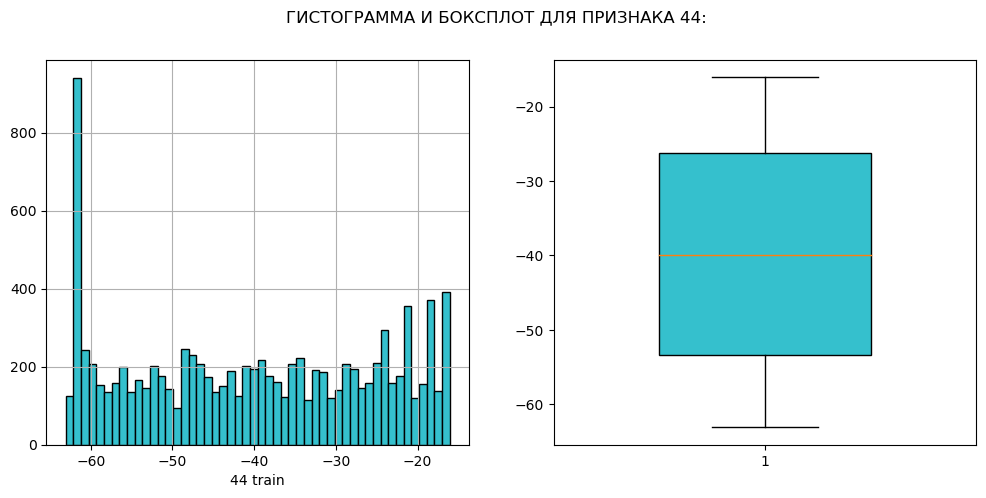

Пороговые значения признака 44:
Нижняя граница значений: -93.98
Верхняя граница значений: 14.36

Описание признака 45:
count    10000.000000
mean        59.145432
std         31.895397
min        -68.001419
25%         37.213495
50%         59.271475
75%         81.687508
max        162.901001
Name: 45, dtype: float64


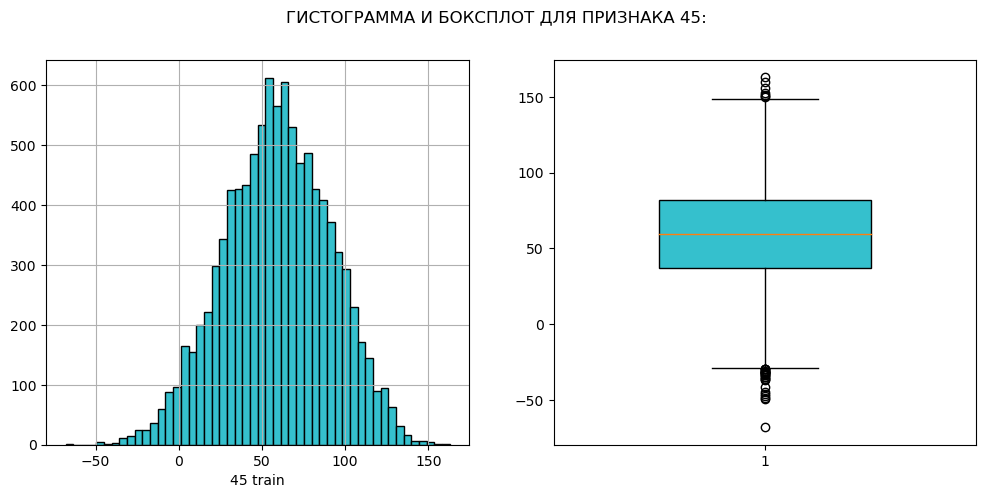

Пороговые значения признака 45:
Нижняя граница значений: -29.5
Верхняя граница значений: 148.4

Описание признака 46:
count    10000.000000
mean       -83.681953
std         64.866867
min       -299.155975
25%       -128.431992
50%        -83.890339
75%        -40.899299
max        160.535675
Name: 46, dtype: float64


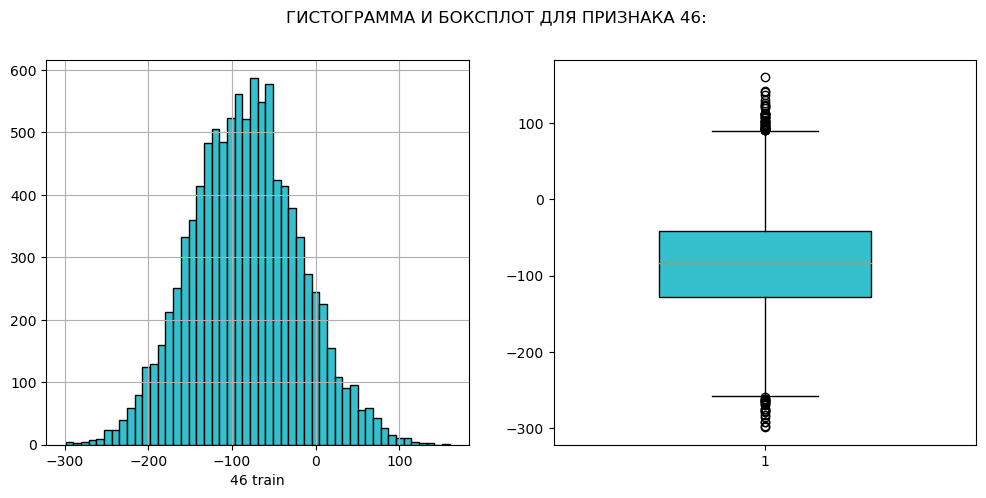

Пороговые значения признака 46:
Нижняя граница значений: -259.73
Верхняя граница значений: 90.4

Описание признака 47:
count    10000.000000
mean      -139.879761
std         58.608433
min       -361.221588
25%       -178.258926
50%       -140.019569
75%       -100.949471
max         96.820251
Name: 47, dtype: float64


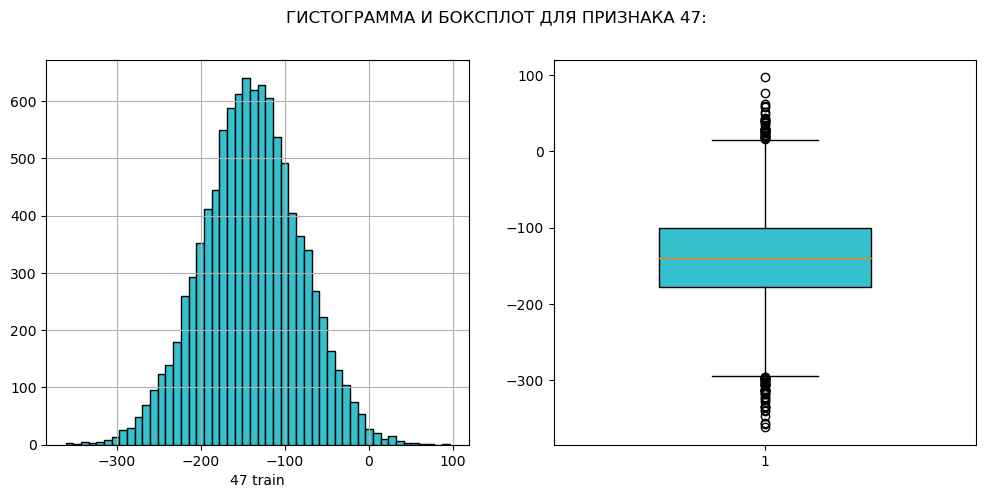

Пороговые значения признака 47:
Нижняя граница значений: -294.22
Верхняя граница значений: 15.01

Описание признака 48:
count    10000.000000
mean        47.308201
std         45.689465
min       -111.352737
25%         17.339963
50%         46.486980
75%         77.523445
max        200.499634
Name: 48, dtype: float64


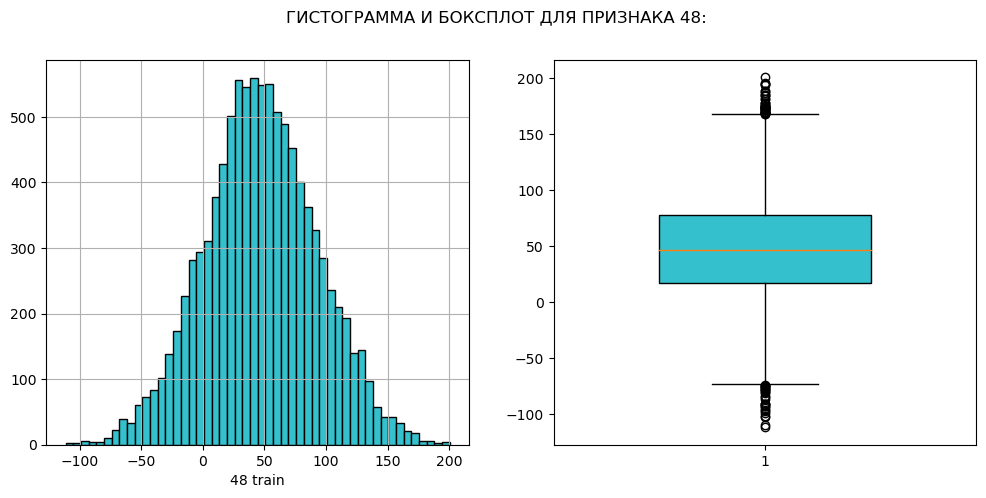

Пороговые значения признака 48:
Нижняя граница значений: -72.94
Верхняя граница значений: 167.8

Описание признака 49:
count    10000.000000
mean       -32.166740
std         58.765537
min       -256.549194
25%        -70.187878
50%        -28.892692
75%          8.646978
max        159.609146
Name: 49, dtype: float64


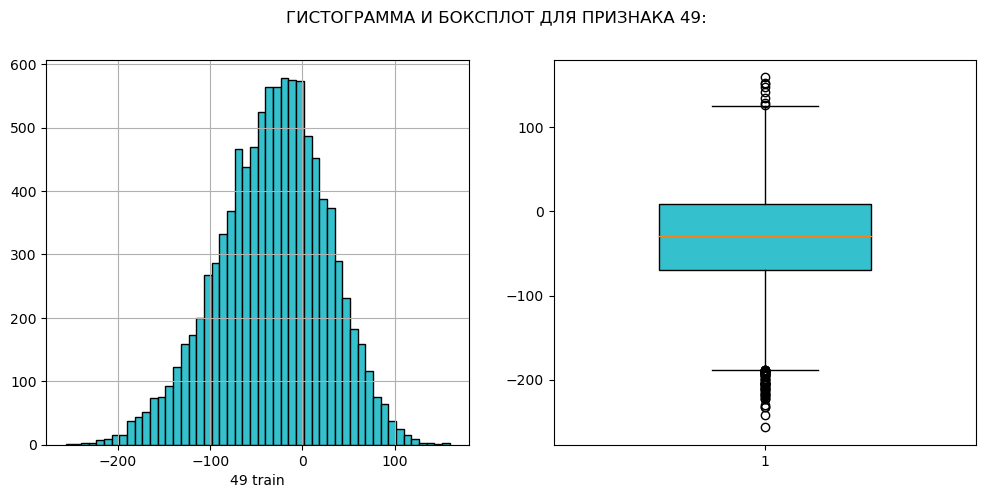

Пороговые значения признака 49:
Нижняя граница значений: -188.44
Верхняя граница значений: 126.9

Описание признака 50:
count    10000.000000
mean        27.867409
std         59.362148
min       -207.818863
25%        -11.466914
50%         28.207611
75%         68.650784
max        228.398346
Name: 50, dtype: float64


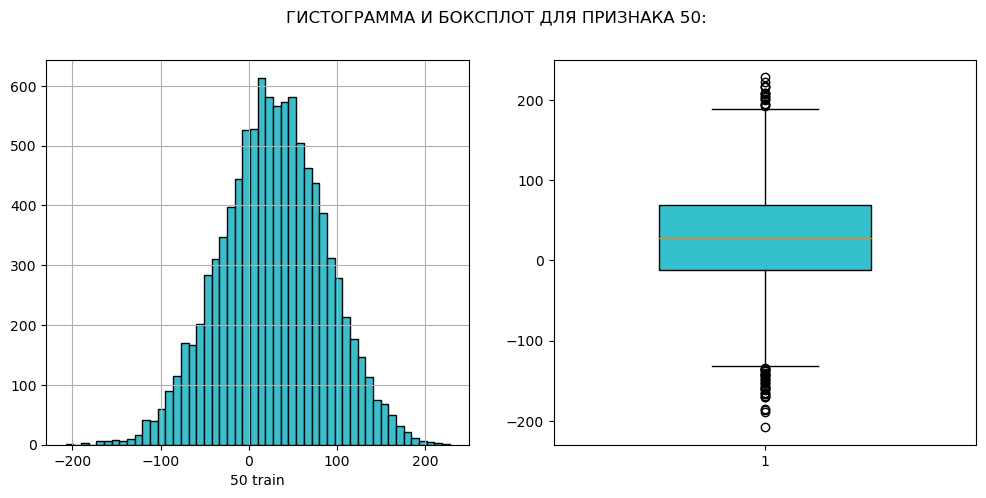

Пороговые значения признака 50:
Нижняя граница значений: -131.64
Верхняя граница значений: 188.83

Описание признака 51:
count    10000.000000
mean       -22.943600
std         53.104500
min       -202.325714
25%        -58.941051
50%        -24.092274
75%         12.274427
max        198.234787
Name: 51, dtype: float64


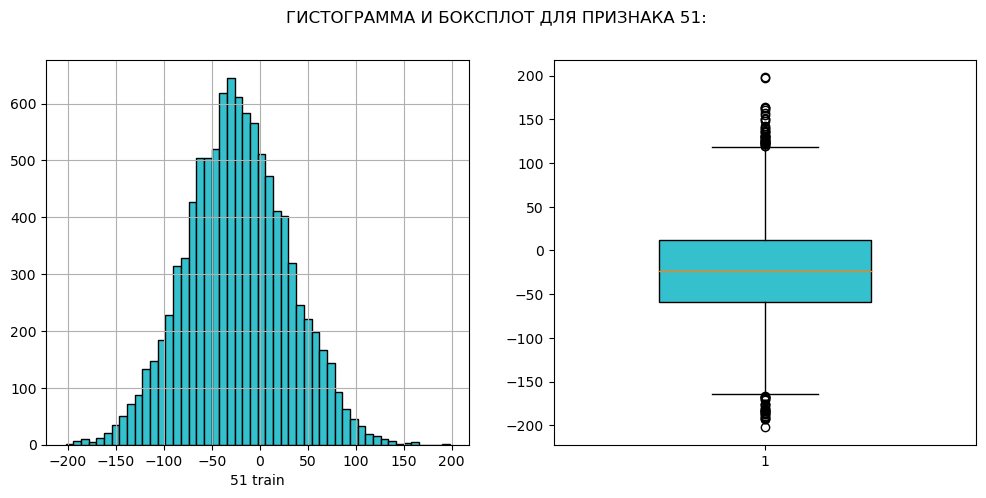

Пороговые значения признака 51:
Нижняя граница значений: -165.76
Верхняя граница значений: 119.1

Описание признака 52:
count    10000.000000
mean        67.218147
std         12.984645
min         17.291992
25%         58.431057
50%         67.255184
75%         76.159349
max        110.243942
Name: 52, dtype: float64


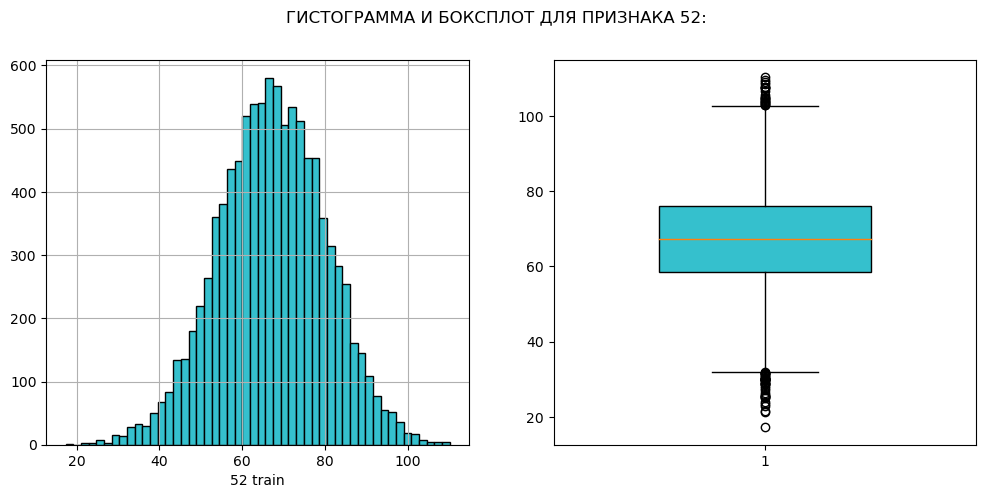

Пороговые значения признака 52:
Нижняя граница значений: 31.84
Верхняя граница значений: 102.75

Описание признака 53:
count    10000.000000
mean      -118.863266
std         55.056896
min       -345.099091
25%       -155.631367
50%       -118.841743
75%        -81.555607
max         93.897003
Name: 53, dtype: float64


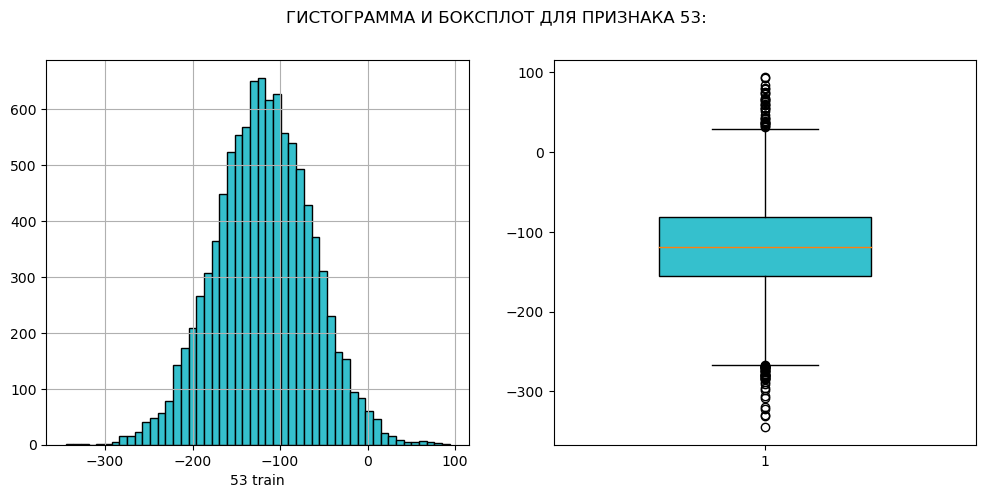

Пороговые значения признака 53:
Нижняя граница значений: -266.75
Верхняя граница значений: 29.56

Описание признака 54:
count    10000.000000
mean        88.107300
std          4.837998
min         70.231262
25%         84.791666
50%         88.154415
75%         91.393801
max        107.090363
Name: 54, dtype: float64


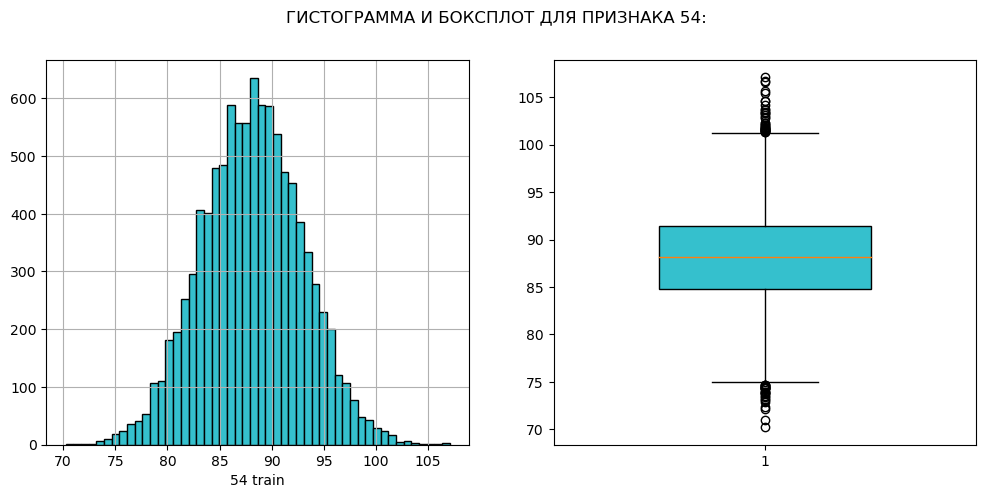

Пороговые значения признака 54:
Нижняя граница значений: 74.89
Верхняя граница значений: 101.3

Описание признака 55:
count    10000.000000
mean        69.294800
std         12.261475
min         21.077629
25%         61.163393
50%         69.525852
75%         77.422438
max        113.675171
Name: 55, dtype: float64


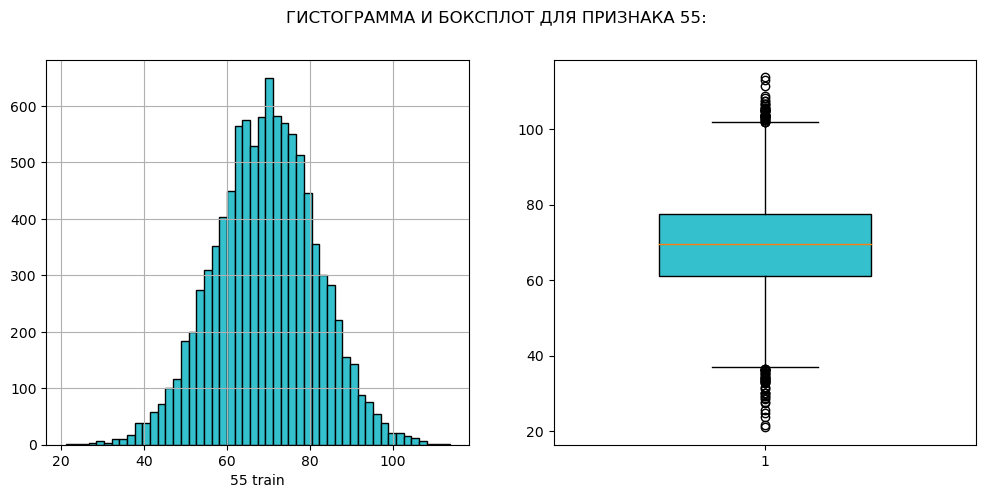

Пороговые значения признака 55:
Нижняя граница значений: 36.77
Верхняя граница значений: 101.81

Описание признака 56:
count    10000.000000
mean      -132.746506
std          7.832571
min       -161.323944
25%       -138.068649
50%       -132.610092
75%       -127.370119
max       -100.514465
Name: 56, dtype: float64


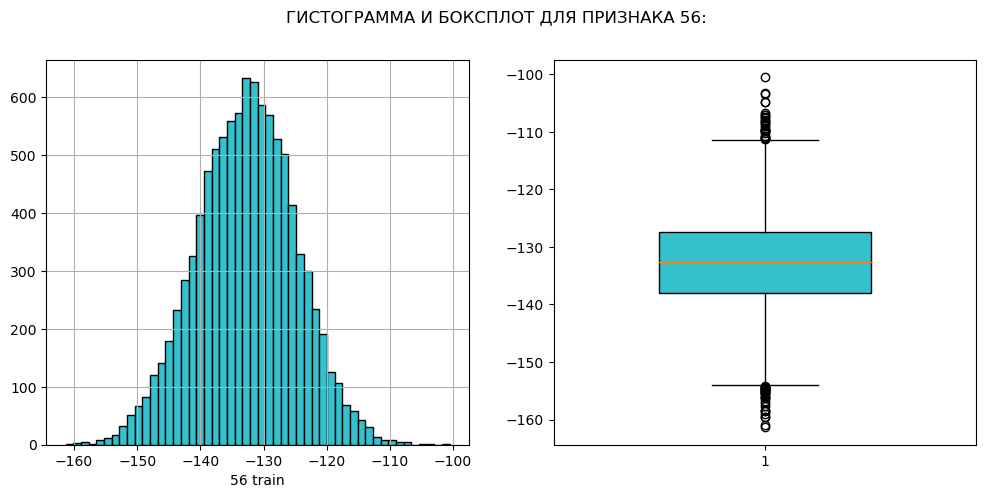

Пороговые значения признака 56:
Нижняя граница значений: -154.12
Верхняя граница значений: -111.32

Описание признака 57:
count    10000.000000
mean        14.126841
std         50.125603
min       -147.846451
25%        -19.893023
50%         13.416261
75%         48.701858
max        181.172806
Name: 57, dtype: float64


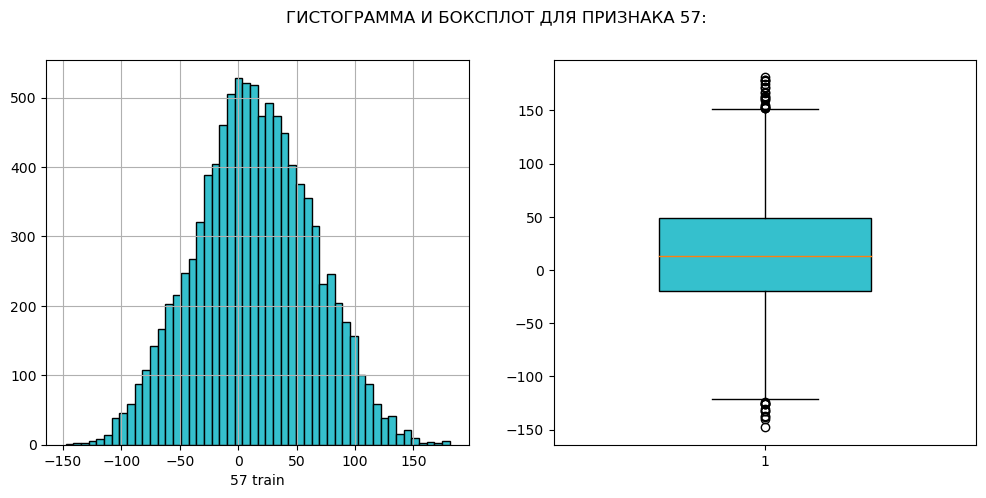

Пороговые значения признака 57:
Нижняя граница значений: -122.79
Верхняя граница значений: 151.59

Описание признака 58:
count    10000.000000
mean      -119.916328
std         55.520267
min       -319.748108
25%       -158.332962
50%       -120.232243
75%        -81.608181
max         69.662445
Name: 58, dtype: float64


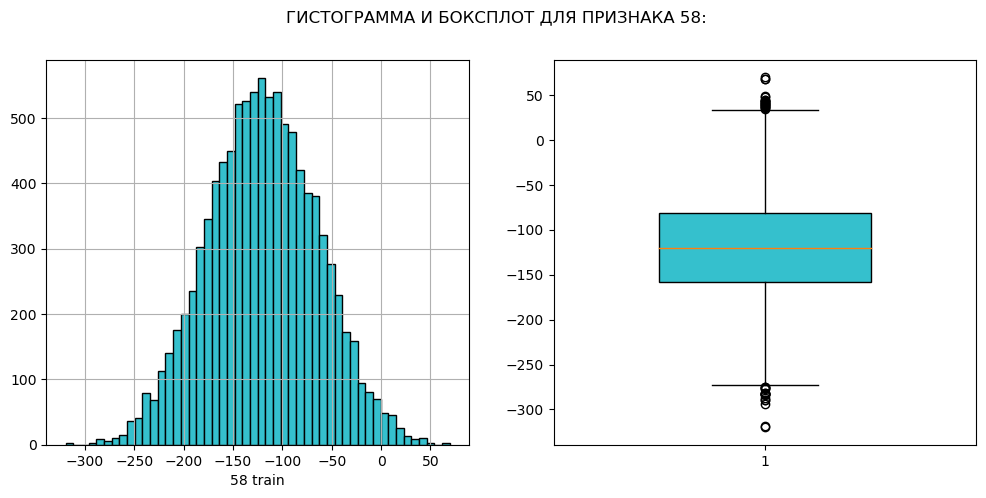

Пороговые значения признака 58:
Нижняя граница значений: -273.42
Верхняя граница значений: 33.48

Описание признака 59:
count    10000.000000
mean      -314.532990
std        210.320847
min       -680.905884
25%       -496.992020
50%       -311.681152
75%       -133.307640
max         48.661400
Name: 59, dtype: float64


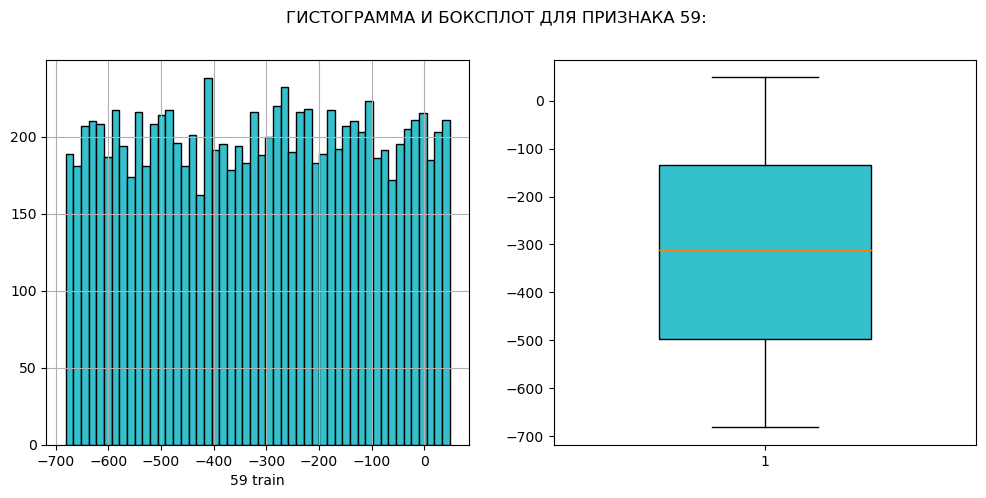

Пороговые значения признака 59:
Нижняя граница значений: -1042.52
Верхняя граница значений: 412.22

Описание признака 60:
count    10000.000000
mean       -65.084984
std         63.449947
min       -296.879913
25%       -107.203236
50%        -64.565784
75%        -21.135728
max        167.217560
Name: 60, dtype: float64


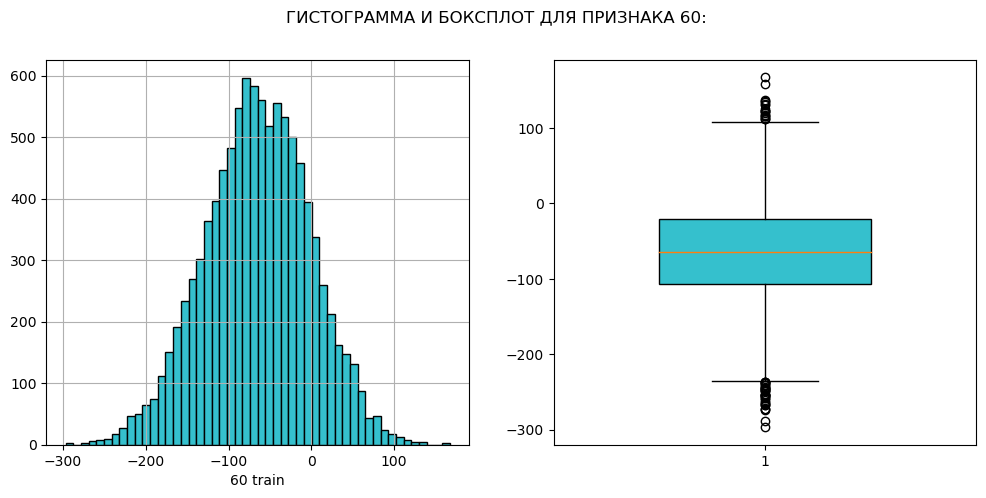

Пороговые значения признака 60:
Нижняя граница значений: -236.3
Верхняя граница значений: 107.97

Описание признака 61:
count    10000.000000
mean      -130.725433
std          9.504219
min       -162.906906
25%       -137.342865
50%       -130.857834
75%       -124.336803
max        -94.505188
Name: 61, dtype: float64


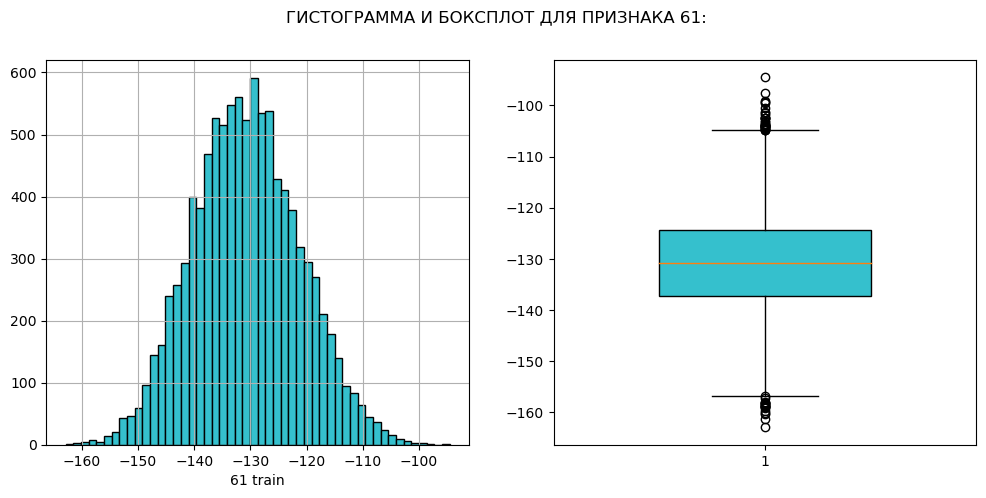

Пороговые значения признака 61:
Нижняя граница значений: -156.85
Верхняя граница значений: -104.83

Описание признака 62:
count    10000.000000
mean       -79.884819
std         30.425508
min       -201.086426
25%        -99.960340
50%        -79.664589
75%        -59.153341
max         31.812820
Name: 62, dtype: float64


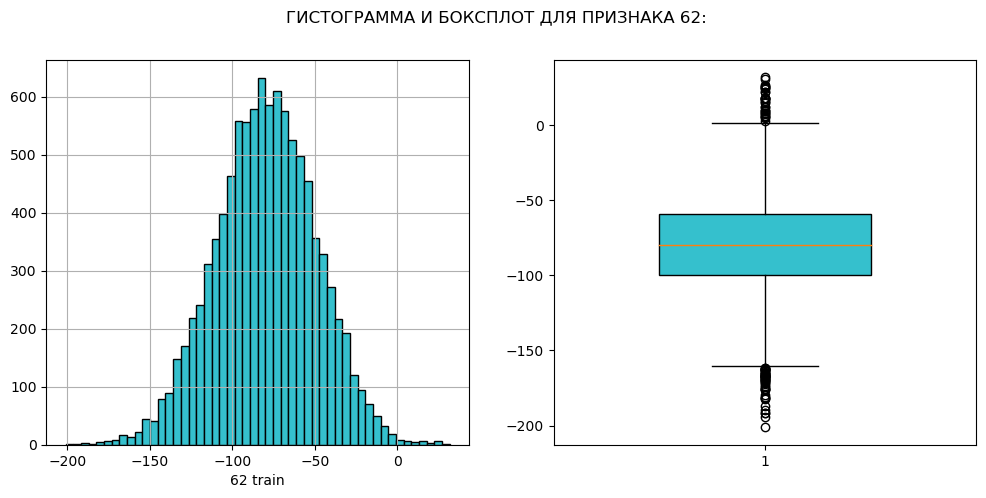

Пороговые значения признака 62:
Нижняя граница значений: -161.17
Верхняя граница значений: 2.06

Описание признака 63:
count    10000.000000
mean        34.564262
std         27.363232
min        -71.393822
25%         18.148289
50%         35.027229
75%         52.771208
max        133.318634
Name: 63, dtype: float64


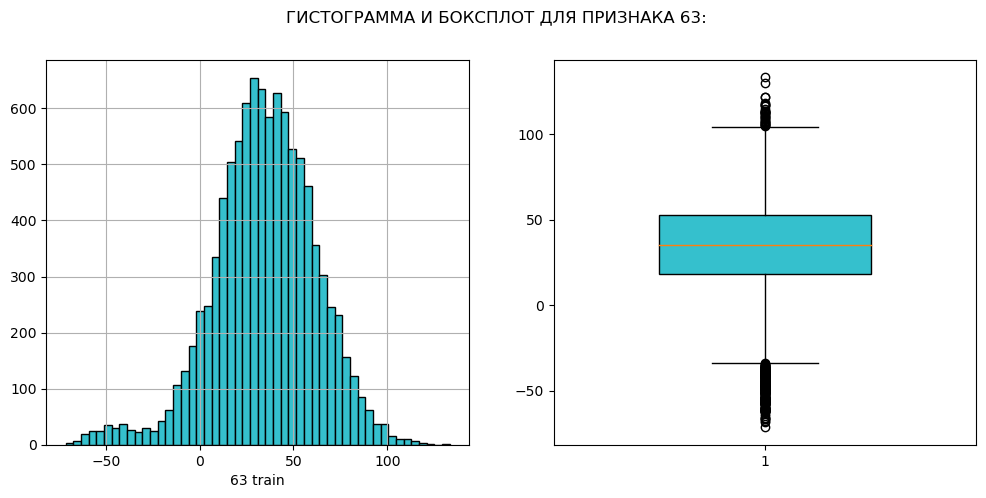

Пороговые значения признака 63:
Нижняя граница значений: -33.79
Верхняя граница значений: 104.71

Описание признака 64:
count    10000.000000
mean      -153.765396
std         41.610378
min       -338.454285
25%       -180.270905
50%       -153.196854
75%       -125.907475
max         -3.190247
Name: 64, dtype: float64


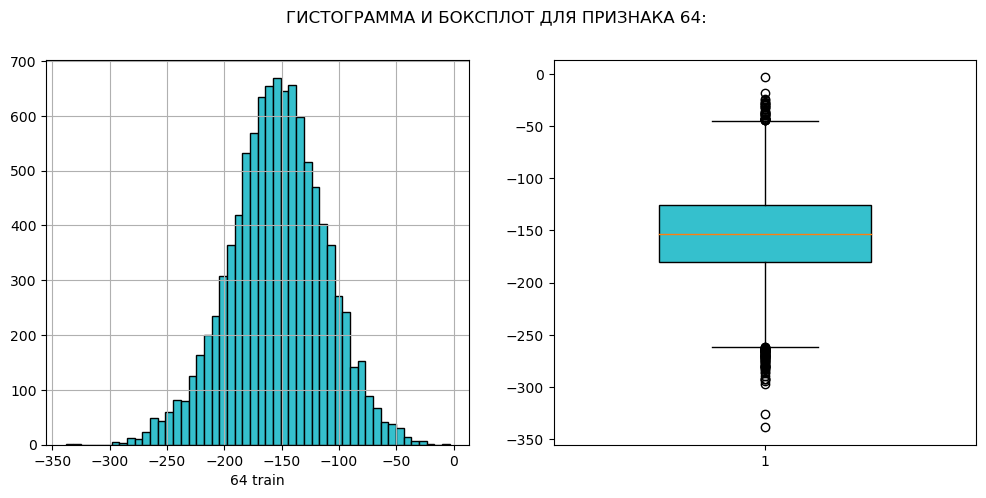

Пороговые значения признака 64:
Нижняя граница значений: -261.82
Верхняя граница значений: -44.36

Описание признака 65:
count    10000.000000
mean        13.424989
std         98.625412
min       -157.583908
25%        -72.098320
50%         14.726140
75%         98.141291
max        185.045074
Name: 65, dtype: float64


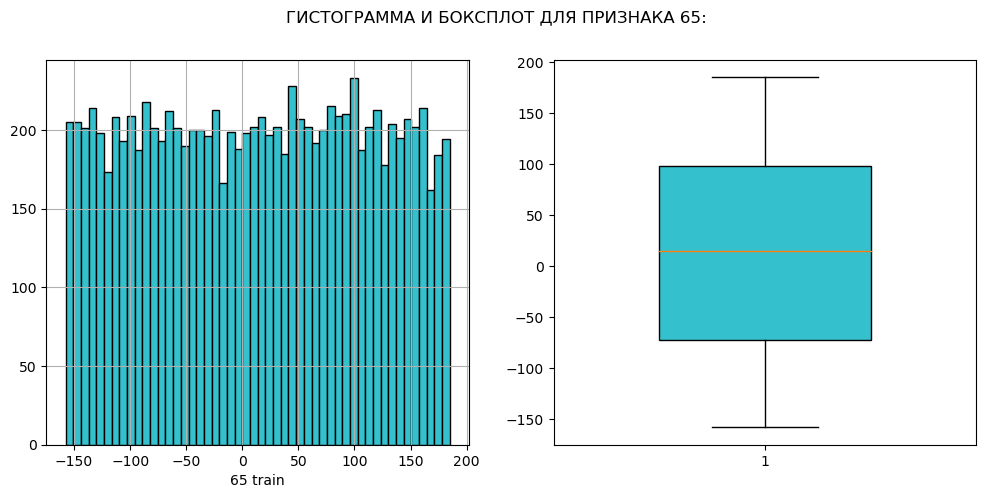

Пороговые значения признака 65:
Нижняя граница значений: -327.46
Верхняя граница значений: 353.5

Описание признака 66:
count    10000.000000
mean        67.770424
std          1.818503
min         61.238895
25%         66.575729
50%         67.792477
75%         68.986139
max         73.948448
Name: 66, dtype: float64


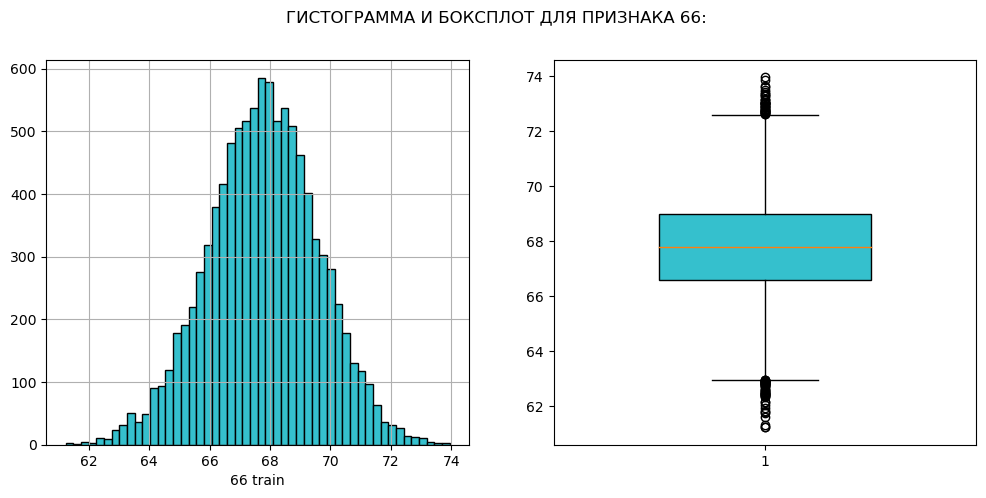

Пороговые значения признака 66:
Нижняя граница значений: 62.96
Верхняя граница значений: 72.6

Описание признака 67:
count    10000.000000
mean        22.931105
std         55.219906
min       -196.846512
25%        -13.176071
50%         23.098784
75%         58.980980
max        228.576721
Name: 67, dtype: float64


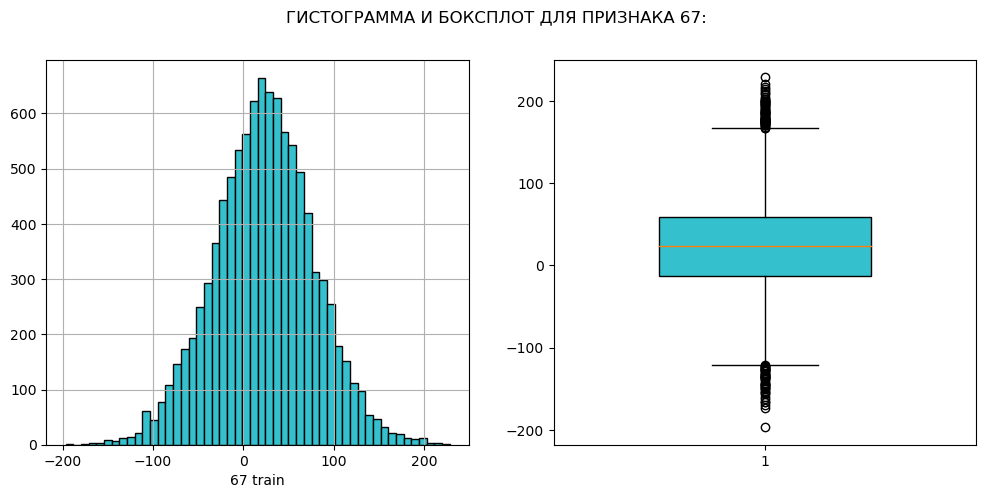

Пороговые значения признака 67:
Нижняя граница значений: -121.41
Верхняя граница значений: 167.22

Описание признака 68:
count    10000.000000
mean        74.253998
std         62.254417
min       -154.867157
25%         32.163138
50%         74.267681
75%        115.709637
max        272.398529
Name: 68, dtype: float64


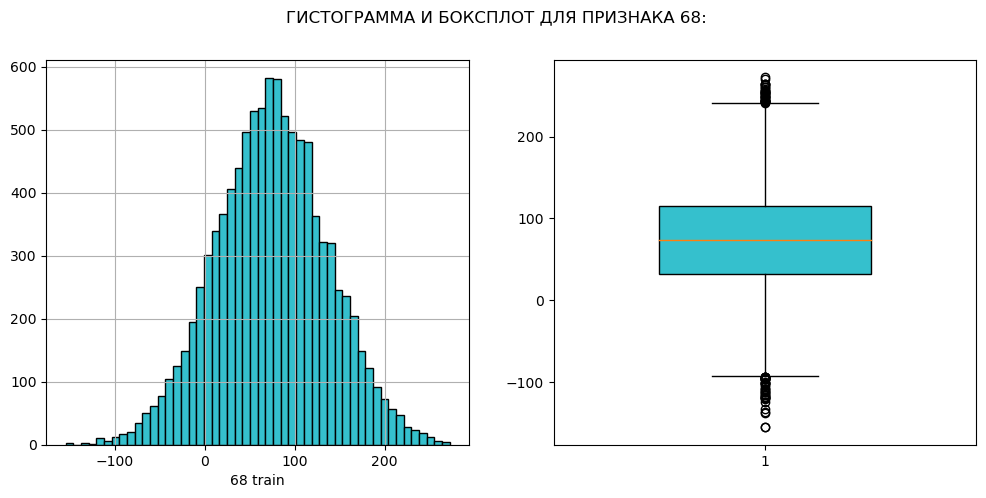

Пороговые значения признака 68:
Нижняя граница значений: -93.16
Верхняя граница значений: 241.03

Описание признака 69:
count    10000.000000
mean       115.520134
std         21.044350
min         30.923660
25%        101.351263
50%        115.810184
75%        129.579582
max        201.320892
Name: 69, dtype: float64


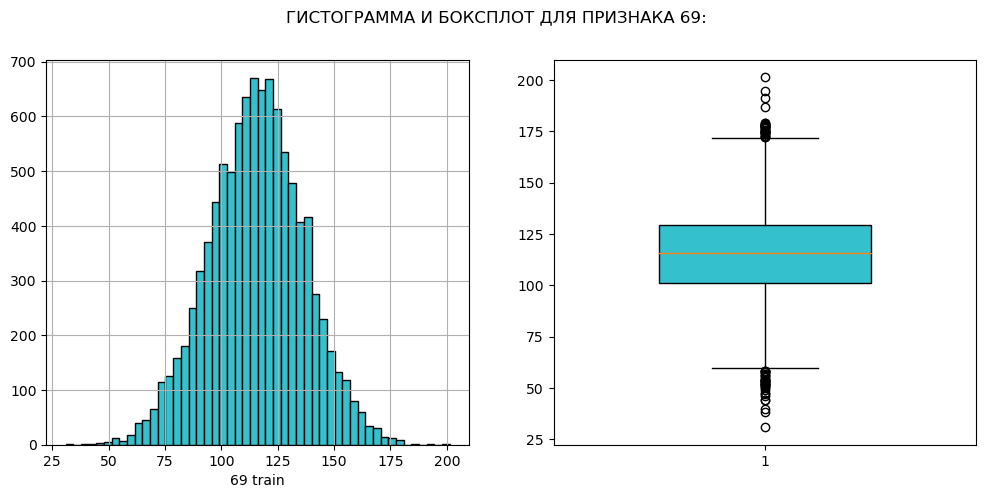

Пороговые значения признака 69:
Нижняя граница значений: 59.01
Верхняя граница значений: 171.92

Описание признака 70:
count    10000.000000
mean      -768.208252
std        392.970367
min      -1297.508057
25%      -1074.464844
50%       -972.766724
75%       -451.393730
max         98.597496
Name: 70, dtype: float64


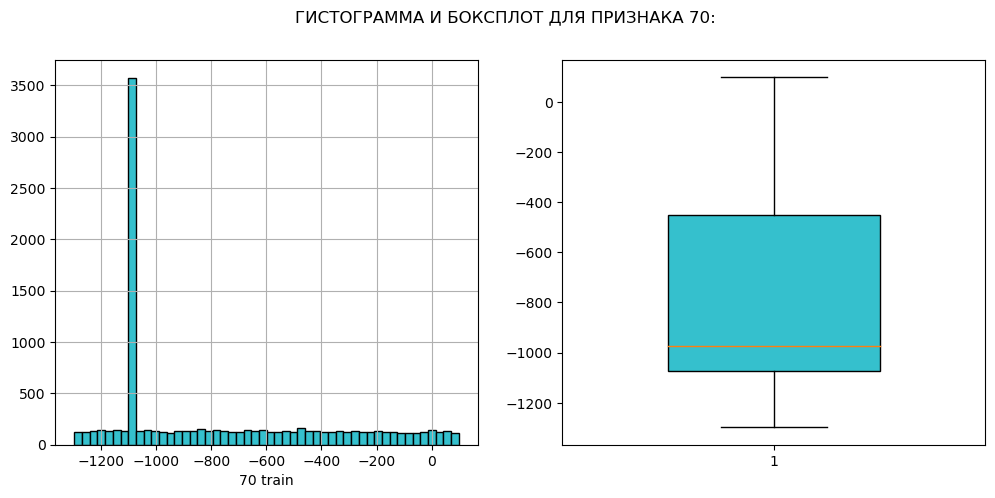

Пороговые значения признака 70:
Нижняя граница значений: -2009.07
Верхняя граница значений: 483.21

Описание признака 71:
count    10000.000000
mean       -48.665085
std         41.829170
min       -192.910965
25%        -76.415556
50%        -49.882122
75%        -20.308755
max        106.825409
Name: 71, dtype: float64


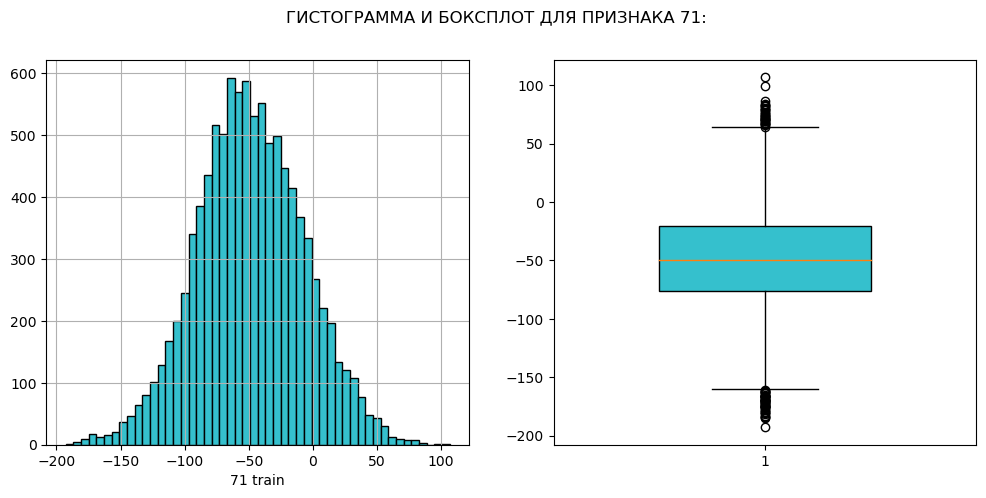

Пороговые значения признака 71:
Нижняя граница значений: -160.58
Верхняя граница значений: 63.85


In [16]:
for j in mini_df_base:
    two_graf(mini_df_base[j], j, 50)

После более подробного изучения гистограмм опишем признаки с ненормальными распределениями:
* Признак 6 - однородное распределение с двумя высокими пиками.
* Признаки 21 и 25 - однородное распределение с одним высоким пиком. Значения, не попадающие в границы данного пика, отображены как выбросы.
* Признак 70 - однородное распределение с одним высоким пиком, но других значений, которые распределились однородно, больше, чем в предыдущих признаках, поэтому они как выбросы не отображены.
* Признак 33 - мультимодальное распределение с множеством неоднородных пиков.
* Признак 44 - однородное распределение с одним невысоким пиком справа и высоким слева.
* Признаки 59 и 65 - практически однородное распределение.

Большая часть признаков (кроме признаков 6, 33 ,44, 59, 65, 70) с выбросами.

## Важность признаков

Так как признаков много, а данные объёмные, хорошо бы избавиться от лишних. Чтобы определить признаки по значимости, воспользуемся моделью машинного обучения RandomForest.

In [17]:
base_targets = df_base.reset_index()
base_targets = base_targets.rename(columns={'Id': 'Targ'})
base_targets = base_targets['Targ']
base_targets = base_targets[:3000]
mini_base = mini_base[:3000]
base_targets

0          0-base
1          1-base
2          2-base
3          3-base
4          4-base
          ...    
2995    2997-base
2996    2998-base
2997    2999-base
2998    3000-base
2999    3001-base
Name: Targ, Length: 3000, dtype: object

In [18]:
train_targets = df_train["Target"]
train_fetures = df_train.drop("Target", axis=1)
train_targets = train_targets[:700]
train_fetures = train_fetures[:700]

In [19]:
columns= mini_base.columns.values.tolist ()

In [20]:
scaler = RobustScaler()

In [21]:
base_fetures = pd.DataFrame(scaler.fit_transform(mini_base), columns=columns)
train_fetures = pd.DataFrame(scaler.fit_transform(train_fetures))

In [22]:
clf=RandomForestClassifier(n_estimators=100, random_state=12345)
clf.fit(base_fetures,base_targets)

RandomForestClassifier(random_state=12345)

In [23]:
feature_imp = pd.Series(clf.feature_importances_,
                         base_fetures.columns)
feature_imp = feature_imp.sort_values()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


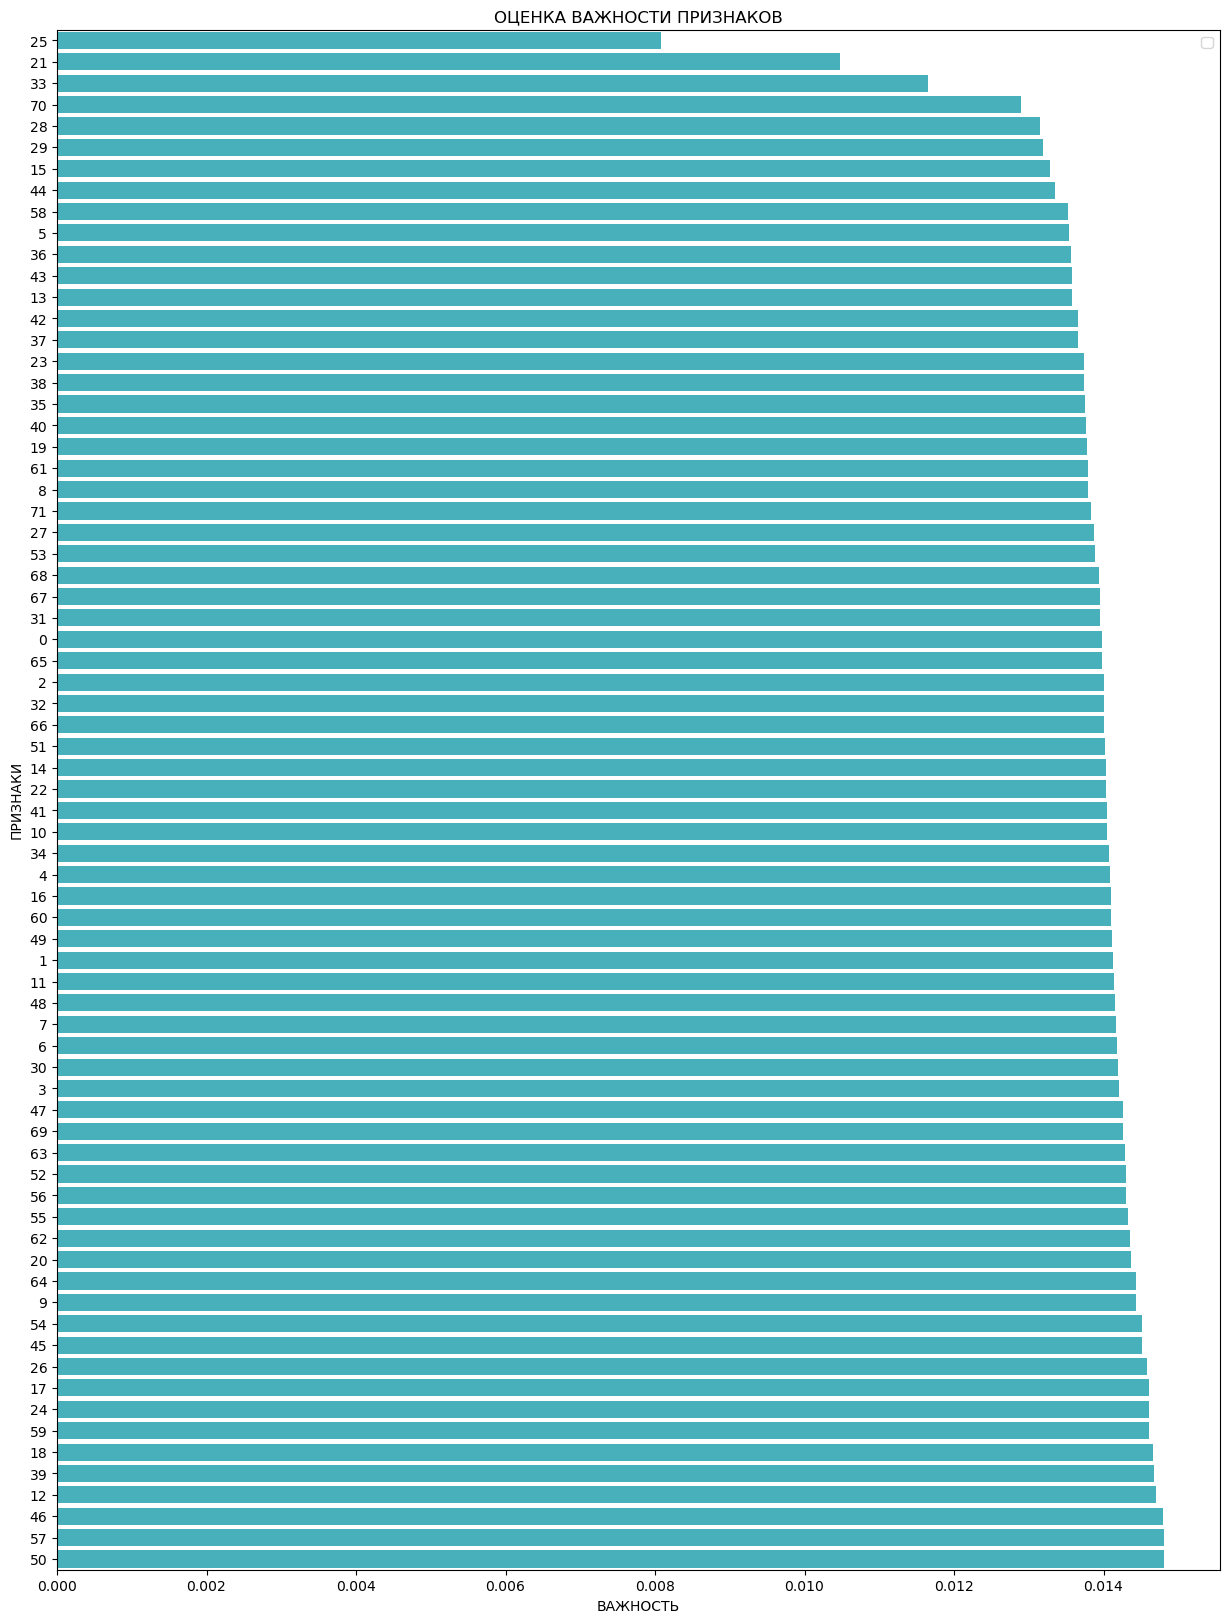

In [24]:
plt.subplots(figsize=(15, 20))
sn.barplot(x=feature_imp, y=feature_imp.index, color = '#35c0cd')
plt.xlabel('ВАЖНОСТЬ')
plt.ylabel('ПРИЗНАКИ')
plt.title("ОЦЕНКА ВАЖНОСТИ ПРИЗНАКОВ")
plt.legend()
plt.show()

## Вывод

В этом разделе были изучены предоставленные данные. Объём данных довольно большой, признаки зашифрованы. Пропущенные значения и дубликаты в датасетах не обнаружены. Далее для изучения распределения данных и взаимодействия между признаками был взят отрезок датасета df_base. Признаки между собой коррелируют слабо. В датасете 25 признаков с высокой мультиколлинеарностью. Гистограммы показали, что большая часть признаков имеет нормальное распределение. Ниже отмечены признаки с ненормальным распределением:
* 6 - однородное распределение с двумя высокими пиками.
* 21 и 25 - однородное распределение с одним высоким пиком. Значения, не попадающие в границы данного пика, отображены как выбросы.
* 70 - однородное распределение с одним высоким пиком, но других значений, которые распределились однородно, больше, чем в предыдущих признаках, поэтому они как выбросы не отображены.
* 33 - мультимодальное распределение с множеством неоднородных пиков.
* 44 - однородное распределение с одним невысоким пиком справа и высоким слева.
* 59 и 65 - практически однородное распределение.

Большая часть признаков с выбросами. Исключения составляют следующие признаки: 6, 33 , 44, 59, 65, 70.

Далее с помощью модели RandomForest признаки были распределены по важности. 

Чтобы ускорить работу алгоритма и поднять оценку метрики на следуюущем этапе предложено провести работу:

* Удаление признаков с высокой мультиколлинеарностью.
* Работа с признаками, отображающими ненормальное распределение.
* Избавление от выбросов.
* Удаление менее важных признаков.
* Масштабирование признаков.
* Кластеризация признаков.
* Построение модели с быстрым поиском.